In [611]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import acf
from scipy import stats
import seaborn as sns
import yfinance as yf
from datetime import datetime
pd.set_option('display.max_columns', None)

In [612]:
# define the date range
start = datetime(2020, 5, 1)
end = datetime(2025, 5, 1)

# Fetch data
df_ndx = yf.download('^NDX', start=start, end=end)
df_jpm = yf.download('JPM', start=start, end=end)
df_usdpln = yf.download('PLN=X', start=start, end=end)
df_brent = yf.download('BZ=F', start=start, end=end)
df_eth = yf.download('ETH-USD', start=start, end=end)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [613]:
dataframes = [df_ndx, df_jpm, df_usdpln, df_brent, df_eth]
tickers = ['NDX', 'JPM', 'USDPLN', 'Brent', 'ETH']

for df in dataframes:
    df.columns = df.columns.droplevel(1)

In [614]:
# Check NaN values
for name, df in zip(tickers, dataframes):
    print(f"NaN values in {name}: {df.isna().sum().sum()}")

NaN values in NDX: 0
NaN values in JPM: 0
NaN values in USDPLN: 0
NaN values in Brent: 0
NaN values in ETH: 0


In [615]:
# Extract 'Close' for each asset and rename the column
data = pd.DataFrame({
    'JPMorgan': df_jpm['Close'],
    'USDPLN': df_usdpln['Close'],
    'BrentOil': df_brent['Close'],
    'Ethereum': df_eth['Close'],
    'NASDAQ': df_ndx['Close']
})


In [616]:
data.ffill(inplace=True)

In [617]:
data['PLNUSD'] = 1 / data['USDPLN']
data.drop(columns=['USDPLN'], inplace=True)

In [618]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD
Date,,,,,
2020-05-01,81.142693,26.440001,214.219101,8718.179688,0.240912
2020-05-02,81.142693,26.440001,215.325378,8718.179688,0.240912
2020-05-03,81.142693,26.440001,210.933151,8718.179688,0.240912
2020-05-04,80.176811,27.200001,208.174011,8834.110352,0.239991
2020-05-05,80.054993,30.969999,206.774399,8930.620117,0.239892
...,...,...,...,...,...
2025-04-26,243.550003,66.870003,1821.881104,19432.560547,0.266406
2025-04-27,243.550003,66.870003,1792.864990,19432.560547,0.266406
2025-04-28,243.220001,65.860001,1798.851807,19427.289062,0.265867


In [619]:
prices = data.copy()

In [620]:
for column in data.columns:
    data[column] = np.log(data[column]).diff()


data.dropna(inplace=True)

In [621]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD
Date,,,,,
2020-05-02,0.000000,0.000000,0.005151,0.000000,0.000000
2020-05-03,0.000000,0.000000,-0.020609,0.000000,0.000000
2020-05-04,-0.011975,0.028339,-0.013167,0.013210,-0.003828
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130
...,...,...,...,...,...
2025-04-26,0.000000,0.000000,0.019536,0.000000,0.000000
2025-04-27,0.000000,0.000000,-0.016055,0.000000,0.000000
2025-04-28,-0.001356,-0.015219,0.003334,-0.000271,-0.002023


In [622]:
n_assets = data.shape[1]
equal_weights = pd.DataFrame(1/n_assets, index=data.index, columns=data.columns)

portfolio_log_returns = (data * equal_weights).sum(axis=1)
data['portfolio'] = portfolio_log_returns

In [623]:
data

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio
Date,,,,,,
2020-05-02,0.000000,0.000000,0.005151,0.000000,0.000000,0.001030
2020-05-03,0.000000,0.000000,-0.020609,0.000000,0.000000,-0.004122
2020-05-04,-0.011975,0.028339,-0.013167,0.013210,-0.003828,0.002516
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415,0.026397
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130,-0.014298
...,...,...,...,...,...,...
2025-04-26,0.000000,0.000000,0.019536,0.000000,0.000000,0.003907
2025-04-27,0.000000,0.000000,-0.016055,0.000000,0.000000,-0.003211
2025-04-28,-0.001356,-0.015219,0.003334,-0.000271,-0.002023,-0.003107


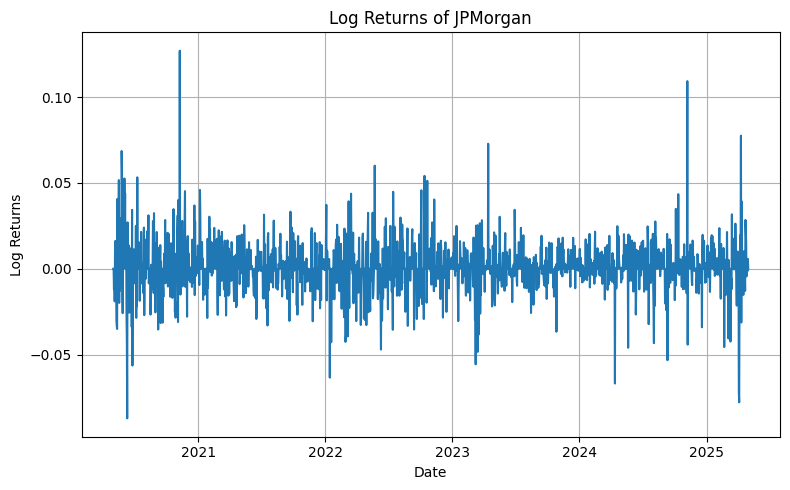

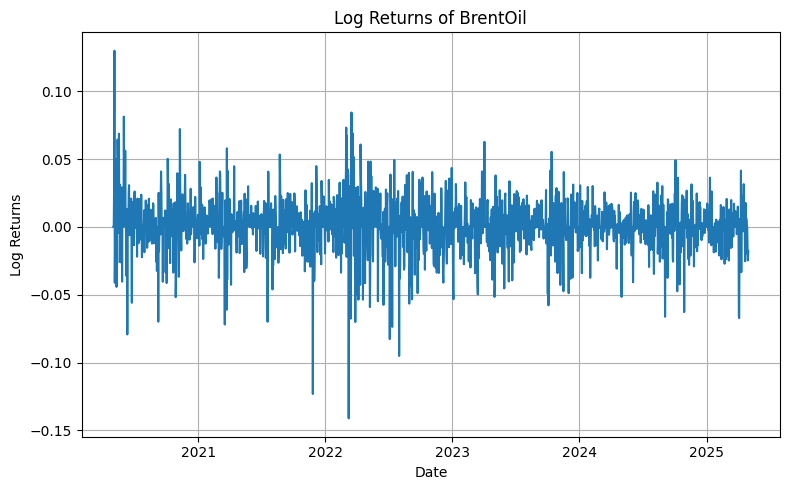

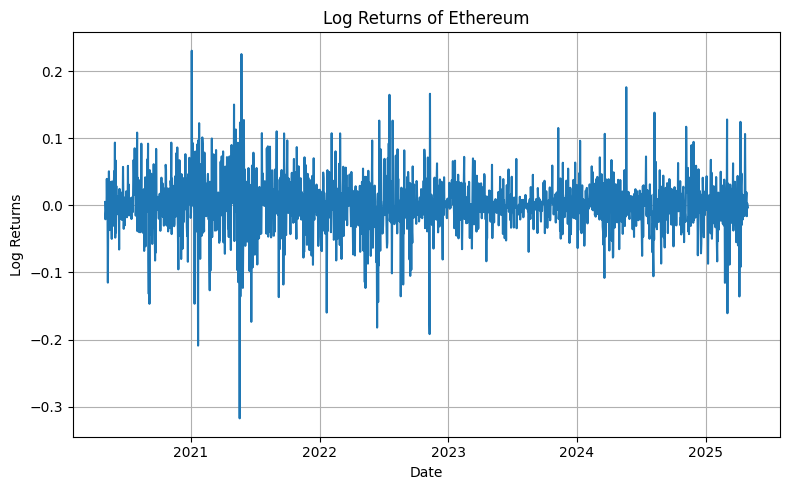

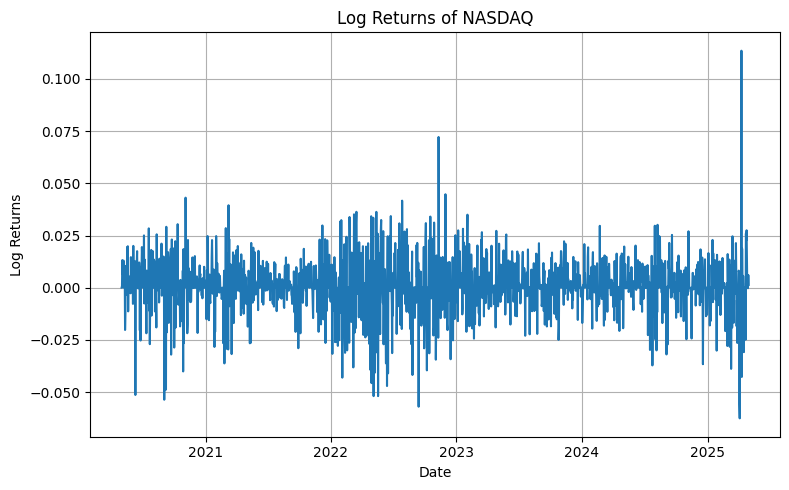

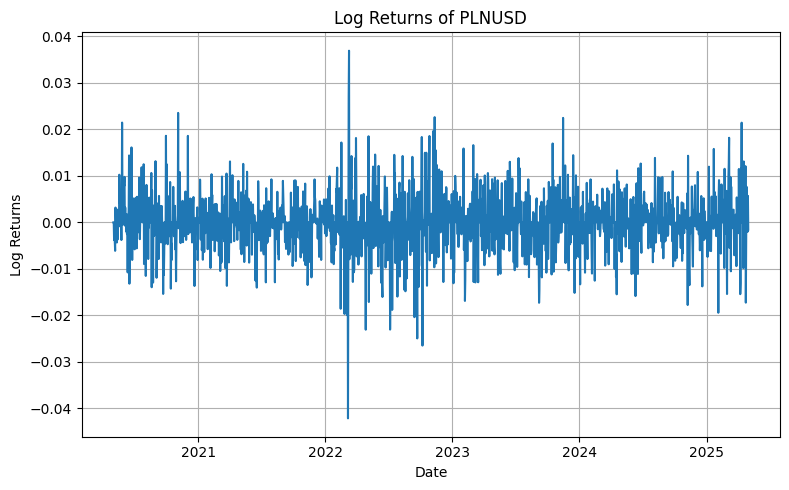

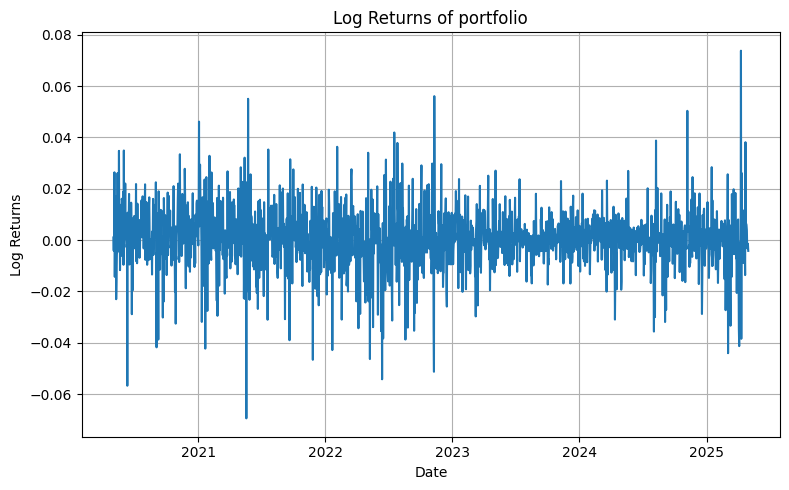

In [624]:
# Generate a plot of each column in the DataFrame
for column in data.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(data.index, data[column], label=column)
    plt.title(f'Log Returns of {column}')
    plt.xlabel('Date')
    plt.ylabel('Log Returns')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [625]:
for column in data.columns:
    print(f"Kurtosis of {column}:", stats.kurtosis(data[column]))

Kurtosis of JPMorgan: 9.802302246320245
Kurtosis of BrentOil: 6.634993283718432
Kurtosis of Ethereum: 4.97964011656886
Kurtosis of NASDAQ: 6.675232368722808
Kurtosis of PLNUSD: 4.206038196333858
Kurtosis of portfolio: 4.105044145258583


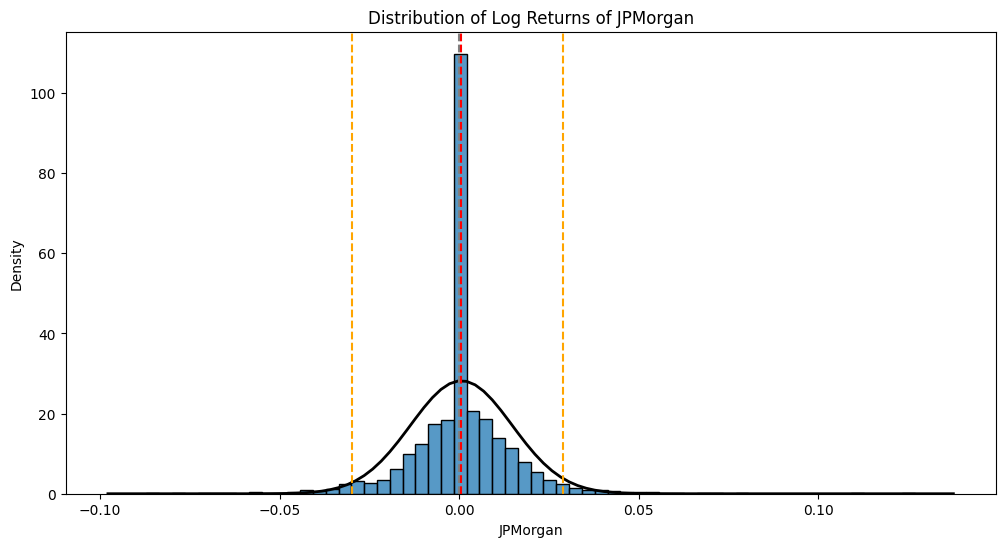

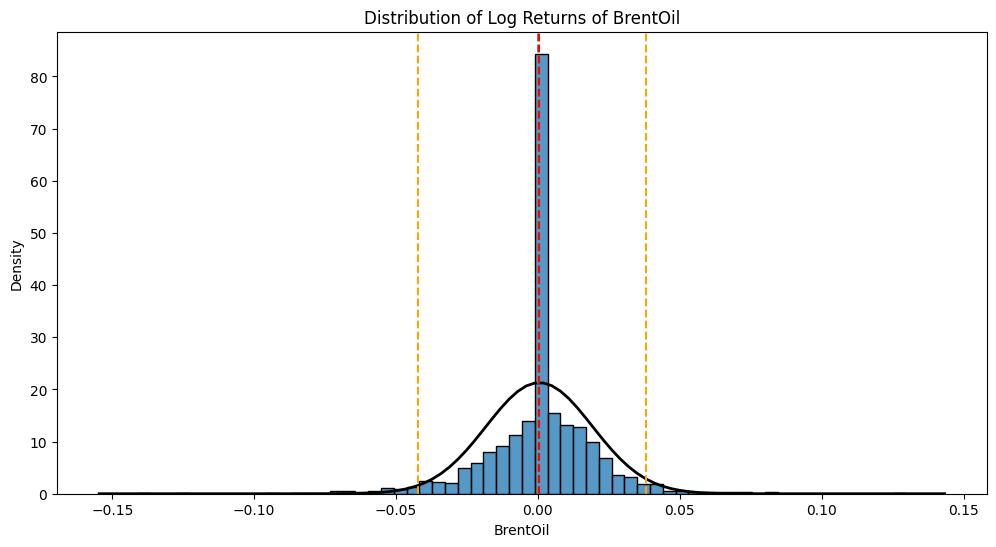

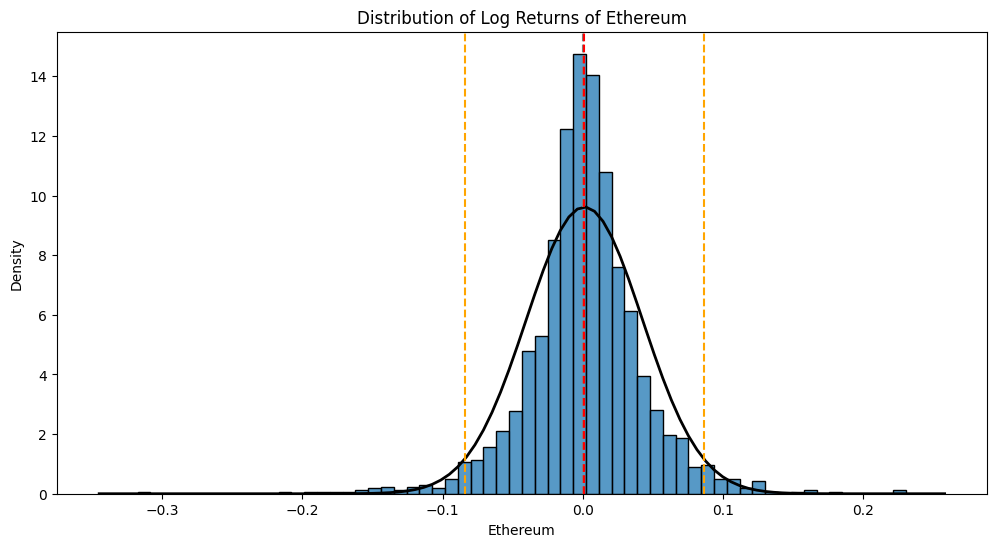

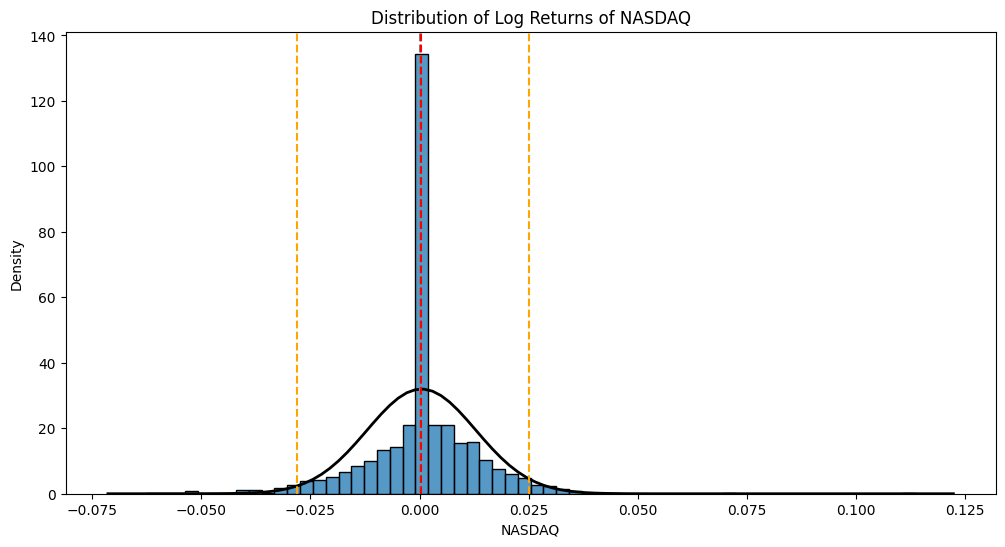

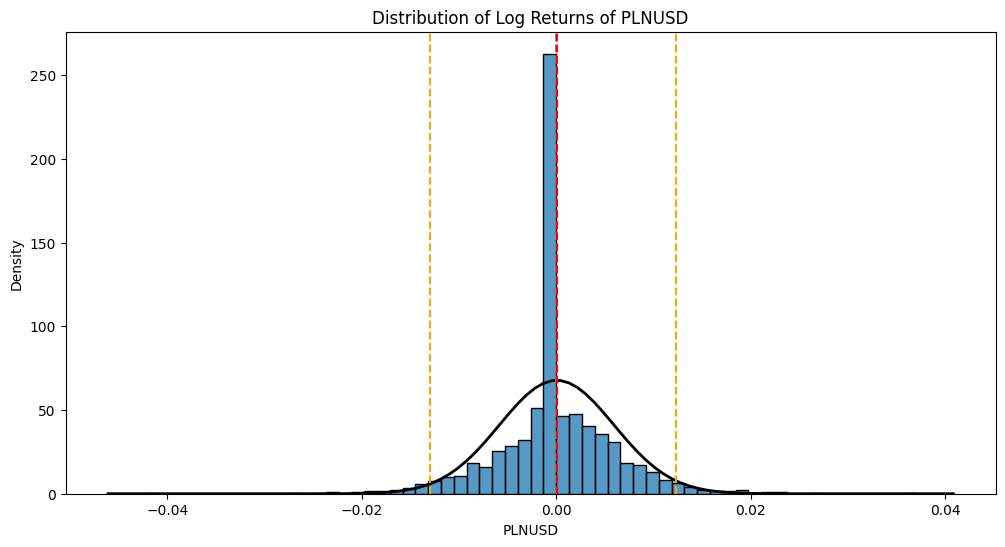

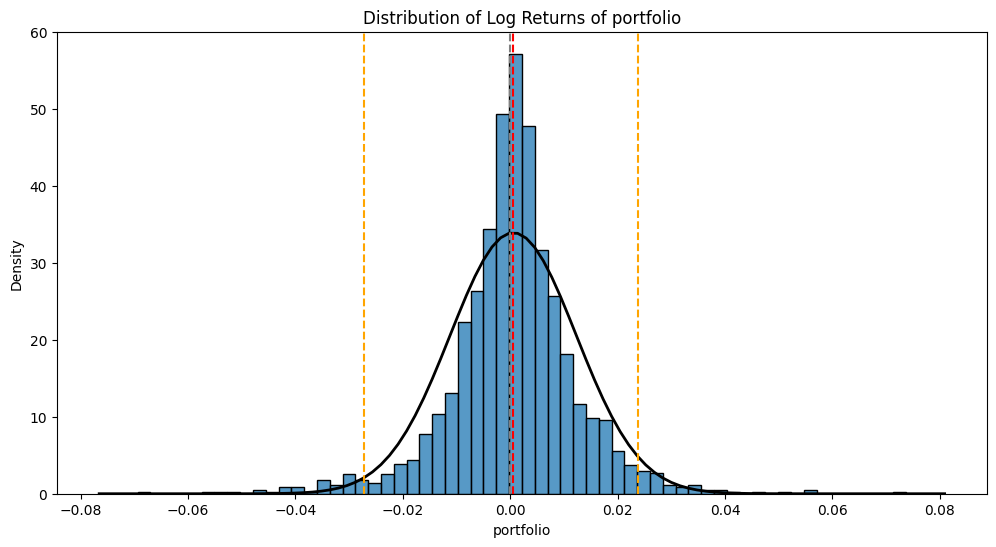

In [626]:
for column in data.columns:
    # Histogram of log returns
    plt.figure(figsize=(12, 6))
    sns.histplot(data[column], stat="density", bins = 60)
    # add normal distribution curve
    mu, std = data[column].mean(), data[column].std()
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    plt.axvline(x=0, linestyle='--', color='gray')
    plt.axvline(x=data[column].mean(), linestyle='--', color='red')
    plt.axvline(x=data[column].quantile(0.025), linestyle='--', color='orange')
    plt.axvline(x=data[column].quantile(0.975), linestyle='--', color='orange')
    plt.title(f'Distribution of Log Returns of {column}')
    plt.show()

In [627]:
for column in data.columns:
    jb_test = stats.jarque_bera(data[column])
    print(f"Jarque-Bera test statistic: {jb_test[0]:.2f}")
    print(f"p-value: {jb_test[1]:.2e}")

Jarque-Bera test statistic: 7371.41
p-value: 0.00e+00
Jarque-Bera test statistic: 3428.27
p-value: 0.00e+00
Jarque-Bera test statistic: 1915.74
p-value: 0.00e+00
Jarque-Bera test statistic: 3389.11
p-value: 0.00e+00
Jarque-Bera test statistic: 1350.61
p-value: 5.22e-294
Jarque-Bera test statistic: 1300.56
p-value: 3.86e-283


In [628]:
# H0: No ARCH effects
# H1: ARCH effects are present

for column in data.columns:
    arch_test_results = het_arch(data[column], nlags=5)

    print(f"LM Statistic {column}: {arch_test_results[0]:.3f}")
    print(f"p-value: {arch_test_results[1]:.3f}")
    print(f"F-statistic {column}: {arch_test_results[2]:.3f}")
    print(f"F p-value: {arch_test_results[3]:.3f}")

LM Statistic JPMorgan: 28.673
p-value: 0.000
F-statistic JPMorgan: 5.807
F p-value: 0.000
LM Statistic BrentOil: 28.281
p-value: 0.000
F-statistic BrentOil: 5.727
F p-value: 0.000
LM Statistic Ethereum: 120.829
p-value: 0.000
F-statistic Ethereum: 25.799
F p-value: 0.000
LM Statistic NASDAQ: 77.902
p-value: 0.000
F-statistic NASDAQ: 16.223
F p-value: 0.000
LM Statistic PLNUSD: 101.108
p-value: 0.000
F-statistic PLNUSD: 21.340
F p-value: 0.000
LM Statistic portfolio: 69.213
p-value: 0.000
F-statistic portfolio: 14.342
F p-value: 0.000


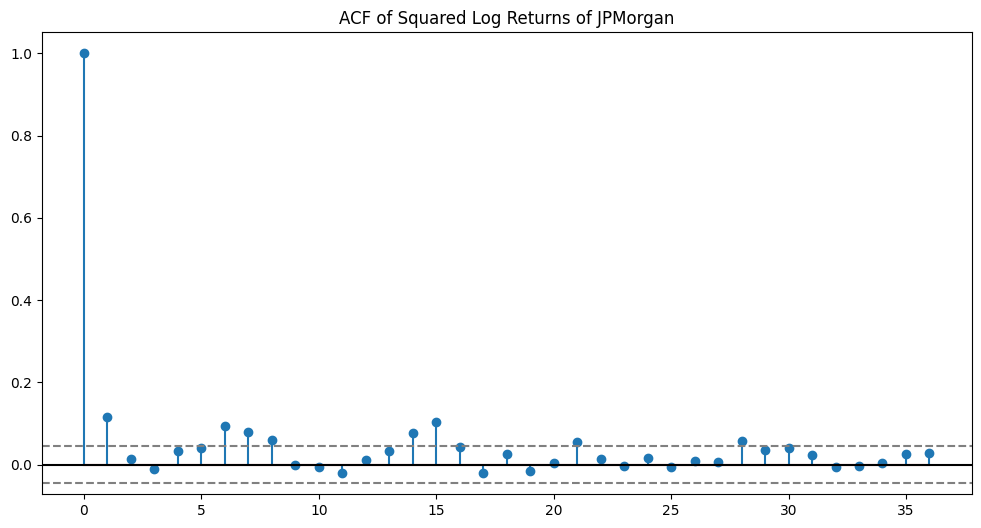

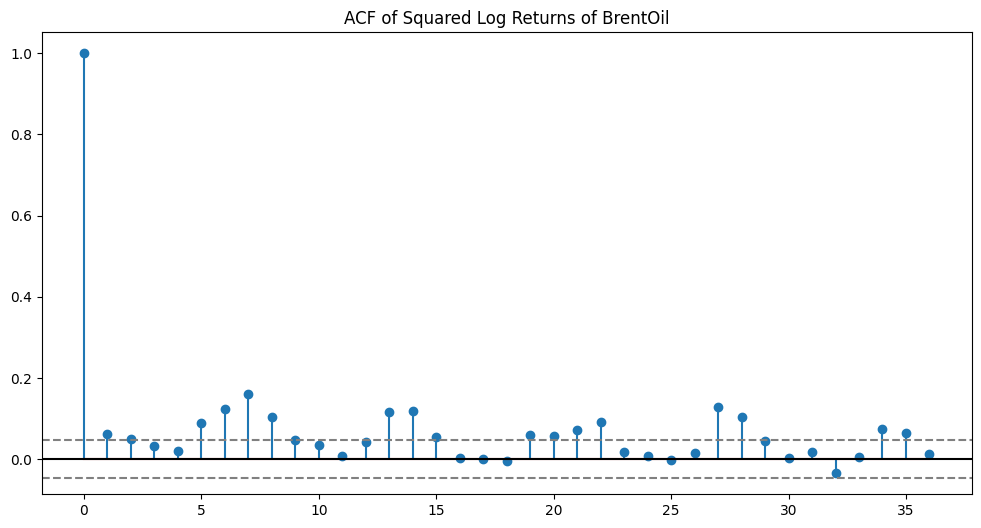

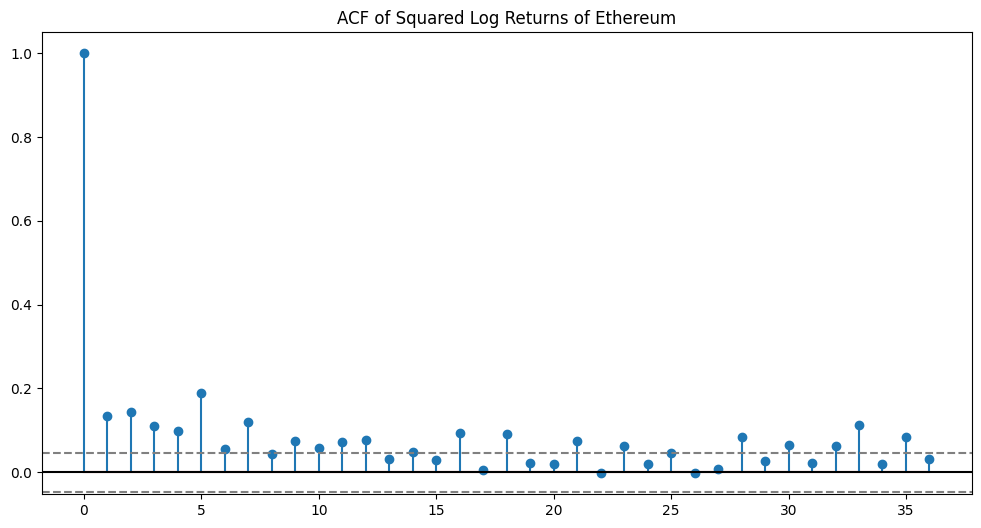

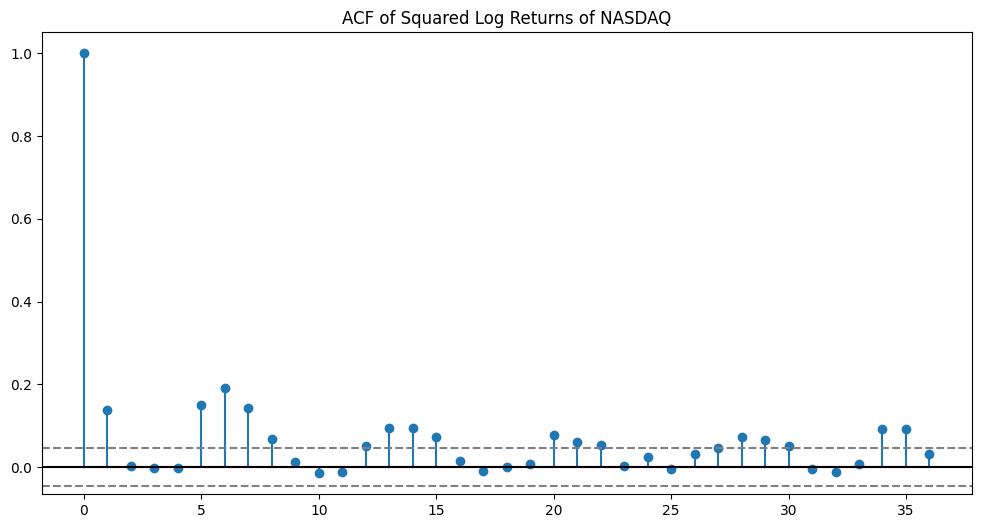

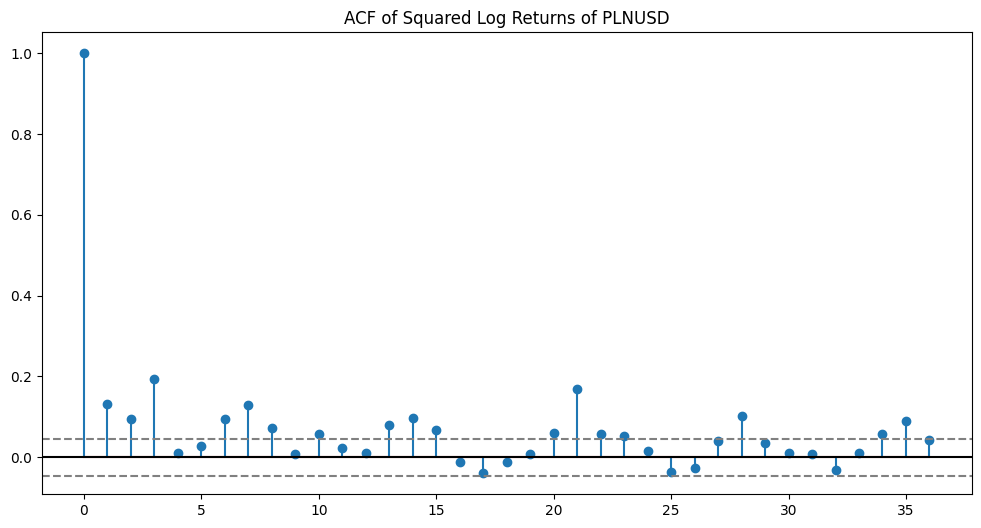

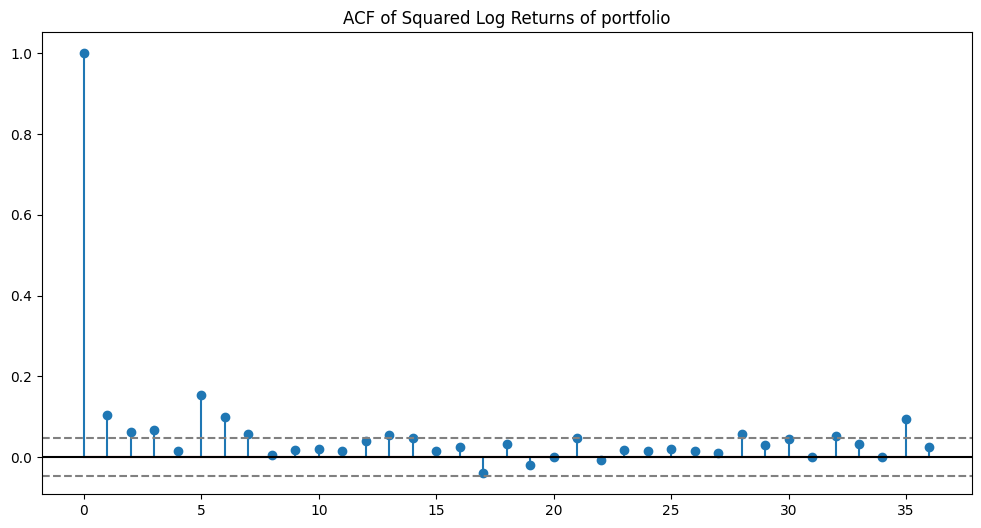

In [629]:
for column in data.columns:
    # Autocorrelation function for squared log returns
    acf_squared = acf(data[column]**2, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf_squared)), acf_squared)
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(data[column])), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data[column])), linestyle='--', color='gray')
    plt.title(f'ACF of Squared Log Returns of {column}')
    plt.show()

In [630]:
data_train = data[data.index < '2024-05-01'].copy()
data_test = data[data.index >= '2024-05-01'].copy()
data_train

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio
Date,,,,,,
2020-05-02,0.000000,0.000000,0.005151,0.000000,0.000000,0.001030
2020-05-03,0.000000,0.000000,-0.020609,0.000000,0.000000,-0.004122
2020-05-04,-0.011975,0.028339,-0.013167,0.013210,-0.003828,0.002516
2020-05-05,-0.001521,0.129802,-0.006746,0.010865,-0.000415,0.026397
2020-05-06,-0.018983,-0.041199,-0.013235,0.006055,-0.004130,-0.014298
...,...,...,...,...,...,...
2024-04-26,0.000620,0.005490,-0.008381,0.016377,0.007059,0.004233
2024-04-27,0.000000,0.000000,0.038236,0.000000,0.000000,0.007647
2024-04-28,0.000000,0.000000,0.003256,0.000000,0.000000,0.000651


In [631]:
model_garch11 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=1)
results_garch11 = model_garch11.fit(disp='off')
print(results_garch11.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2246.67
Distribution:                  Normal   AIC:                           4501.35
Method:            Maximum Likelihood   BIC:                           4522.49
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  2.805e-02      2.569  1.020e-02 [1.708e-0

In [632]:
model_garch12 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=2)
results_garch12 = model_garch12.fit(disp='off')
print(results_garch12.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2246.04
Distribution:                  Normal   AIC:                           4502.08
Method:            Maximum Likelihood   BIC:                           4528.52
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  2.810e-02      2.566  1.029e-02 [1.703e-0

In [633]:
model_garch21 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=1)
results_garch21 = model_garch21.fit(disp='off')
print(results_garch21.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2246.67
Distribution:                  Normal   AIC:                           4503.35
Method:            Maximum Likelihood   BIC:                           4529.78
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  2.843e-02      2.535  1.125e-02 [1.635e-0

In [634]:
model_garch22 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=2)
results_garch22 = model_garch22.fit(disp='off')
print(results_garch22.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2246.46
Distribution:                  Normal   AIC:                           4504.91
Method:            Maximum Likelihood   BIC:                           4536.63
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  2.812e-02      2.566  1.030e-02 [1.703e-0

In [635]:
model_garch10 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=0)
results_garch10 = model_garch10.fit(disp='off')
print(results_garch10.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2315.06
Distribution:                  Normal   AIC:                           4636.12
Method:            Maximum Likelihood   BIC:                           4651.98
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0767  3.118e-02      2.459  1.394e-02 [1.556e-0

In [636]:
model_garch20 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=0)
results_garch20 = model_garch20.fit(disp='off')
print(results_garch20.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2306.55
Distribution:                  Normal   AIC:                           4621.10
Method:            Maximum Likelihood   BIC:                           4642.24
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0891  3.146e-02      2.832  4.625e-03 [2.743e-0

In [637]:
model_garch31 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=1)
results_garch31 = model_garch31.fit(disp='off')
print(results_garch31.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2246.67
Distribution:                  Normal   AIC:                           4505.35
Method:            Maximum Likelihood   BIC:                           4537.06
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  2.880e-02      2.503  1.233e-02 [1.562e-0

In [638]:
model_garch32 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=2)
results_garch32 = model_garch32.fit(disp='off')
print(results_garch32.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2246.46
Distribution:                  Normal   AIC:                           4506.91
Method:            Maximum Likelihood   BIC:                           4543.91
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0721  2.852e-02      2.530  1.142e-02 [1.624e-0

In [639]:
model_garch13 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=1, q=3)
results_garch13 = model_garch13.fit(disp='off')
print(results_garch13.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2245.91
Distribution:                  Normal   AIC:                           4503.82
Method:            Maximum Likelihood   BIC:                           4535.54
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0727  2.801e-02      2.595  9.448e-03 [1.780e-0

In [640]:
model_garch23 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=2, q=3)
results_garch23 = model_garch23.fit(disp='off')
print(results_garch23.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2244.96
Distribution:                  Normal   AIC:                           4503.91
Method:            Maximum Likelihood   BIC:                           4540.92
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0715  2.803e-02      2.551  1.073e-02 [1.658e-0

In [641]:
model_garch33 = arch_model(data_train['portfolio'] * 100, vol='Garch', p=3, q=3)
results_garch33 = model_garch33.fit(disp='off')
print(results_garch33.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2244.96
Distribution:                  Normal   AIC:                           4505.91
Method:            Maximum Likelihood   BIC:                           4548.20
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:56   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0715  2.807e-02      2.548  1.083e-02 [1.651e-0

In [642]:
models = {
    'GARCH(1,1)': results_garch11,
    'GARCH(1,2)': results_garch12,
    'GARCH(2,1)': results_garch21,
    'GARCH(2,2)': results_garch22,
    'GARCH(1,0)': results_garch10,
    'GARCH(2,0)': results_garch20,
    'GARCH(3,1)': results_garch31,
    'GARCH(3,2)': results_garch32,
    'GARCH(1,3)': results_garch13,
    'GARCH(2,3)': results_garch23,
    'GARCH(3,3)': results_garch33
}

In [643]:
def compare_arch_models(model_results_dict):
    if not model_results_dict:
        print("No model results provided.")
        return pd.DataFrame()

    ic_data = []
    for name, model in model_results_dict.items():
        if hasattr(model, 'aic') and hasattr(model, 'bic'):
            ic_data.append({
                'Model': name,
                'lb_5' : sm.stats.acorr_ljungbox(model.std_resid, lags=[5], return_df=True)['lb_pvalue'].iloc[0],
                'lb_10' : sm.stats.acorr_ljungbox(model.std_resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
                'lb_15' : sm.stats.acorr_ljungbox(model.std_resid, lags=[15], return_df=True)['lb_pvalue'].iloc[0],
                'lb_20' : sm.stats.acorr_ljungbox(model.std_resid, lags=[20], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_5' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[5], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_10' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[10], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_15' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[15], return_df=True)['lb_pvalue'].iloc[0],
                'lb_sq_20' : sm.stats.acorr_ljungbox(model.std_resid**2, lags=[20], return_df=True)['lb_pvalue'].iloc[0],
                'het_arch_LM': het_arch(model.std_resid, nlags=5)[1],
                'het_arch_F': het_arch(model.std_resid, nlags=5)[3],
                'AIC': model.aic,
                'BIC': model.bic,
                'LogLikelihood': model.loglikelihood,
                'Num Params': len(model.params)
            })
        else:
            print(f"Warning: Model {name} does not have standard IC attributes.")
            ic_data.append({
                'Model': name,
                'AIC': np.nan,
                'BIC': np.nan,
                'LogLikelihood': np.nan,
                'Num Params': np.nan
            })
            
    ic_df = pd.DataFrame(ic_data)
    if not ic_df.empty:
      ic_df = ic_df.set_index('Model')
    return ic_df

In [644]:
compare_arch_models(models)

,lb_5,lb_10,lb_15,lb_20,lb_sq_5,lb_sq_10,lb_sq_15,lb_sq_20,het_arch_LM,het_arch_F,AIC,BIC,LogLikelihood,Num Params
Model,,,,,,,,,,,,,,
"GARCH(1,1)",0.257954,0.275936,0.174405,0.378798,7.002033e-03,3.635374e-02,7.914677e-02,1.852896e-02,6.642868e-03,6.534430e-03,4501.345837,4522.490604,-2246.672919,4
"GARCH(1,2)",0.270927,0.280953,0.187193,0.398268,9.964571e-03,4.602195e-02,9.103551e-02,2.041427e-02,9.361311e-03,9.234324e-03,4502.084836,4528.515794,-2246.042418,5
"GARCH(2,1)",0.257952,0.275934,0.174404,0.378797,7.001411e-03,3.635149e-02,7.914323e-02,1.852841e-02,6.642299e-03,6.533866e-03,4503.345837,4529.776796,-2246.672919,5
"GARCH(2,2)",0.263278,0.278979,0.177034,0.387912,1.029348e-02,4.662540e-02,9.253020e-02,2.061556e-02,9.839557e-03,9.709862e-03,4504.910885,4536.628035,-2246.455442,6
"GARCH(1,0)",0.073759,0.095759,0.045817,0.145679,9.566586e-10,5.674894e-10,2.906644e-10,7.466078e-10,4.823889e-09,3.573678e-09,4636.121087,4651.979662,-2315.060544,3
"GARCH(2,0)",0.101024,0.150800,0.049898,0.155399,1.274292e-06,1.963234e-06,6.625863e-07,1.477248e-06,1.037635e-06,8.889687e-07,4621.100031,4642.244798,-2306.550016,4
"GARCH(3,1)",0.257952,0.275934,0.174404,0.378797,7.001075e-03,3.635031e-02,7.914127e-02,1.852805e-02,6.641999e-03,6.533568e-03,4505.345837,4537.062988,-2246.672919,6
"GARCH(3,2)",0.263279,0.278979,0.177034,0.387910,1.029363e-02,4.662603e-02,9.253091e-02,2.061559e-02,9.839623e-03,9.709928e-03,4506.910885,4543.914227,-2246.455442,7
"GARCH(1,3)",0.255589,0.272718,0.169466,0.370474,1.090610e-02,5.124973e-02,1.030542e-01,2.428697e-02,1.110855e-02,1.097232e-02,4503.820706,4535.537856,-2245.910353,6


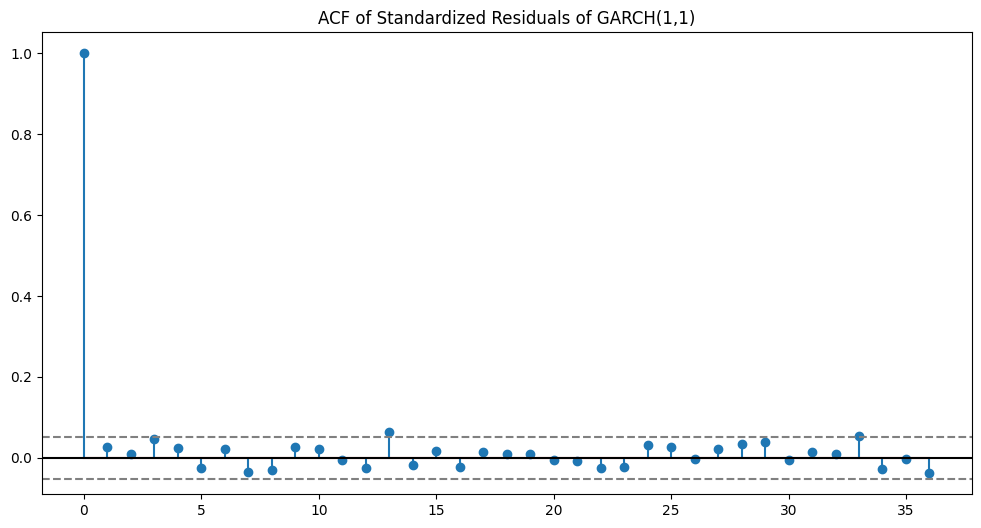

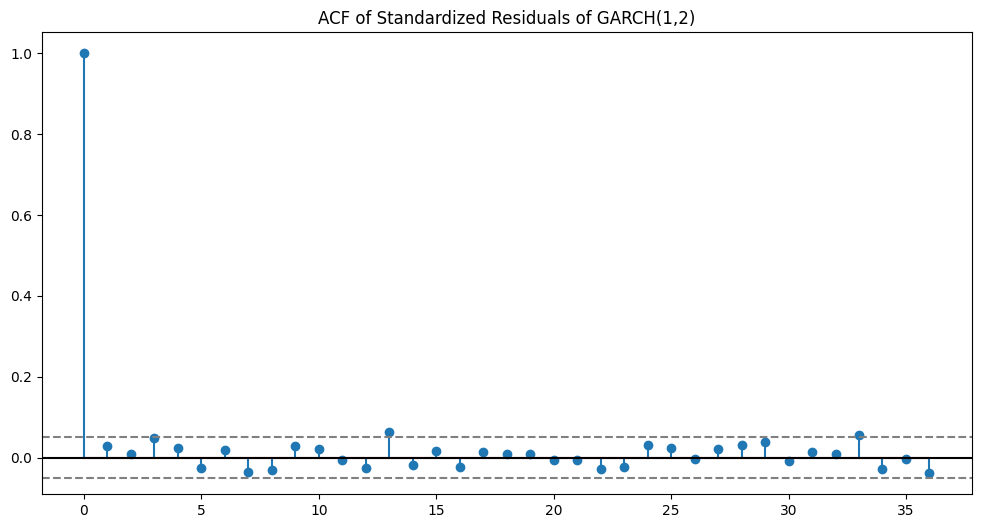

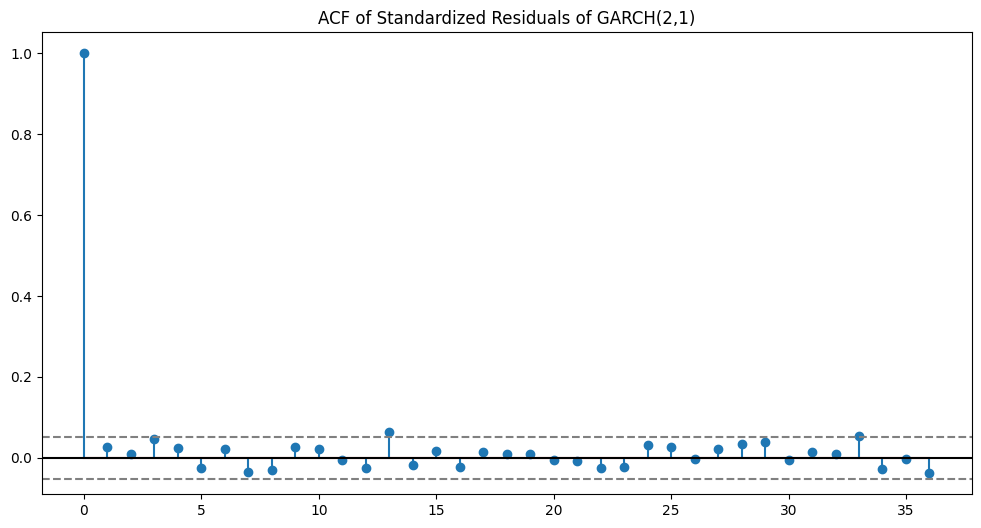

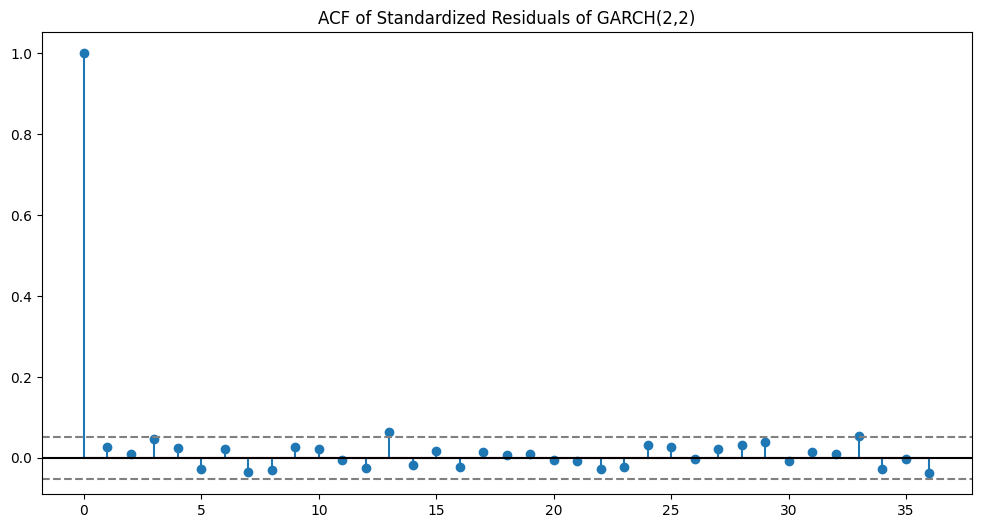

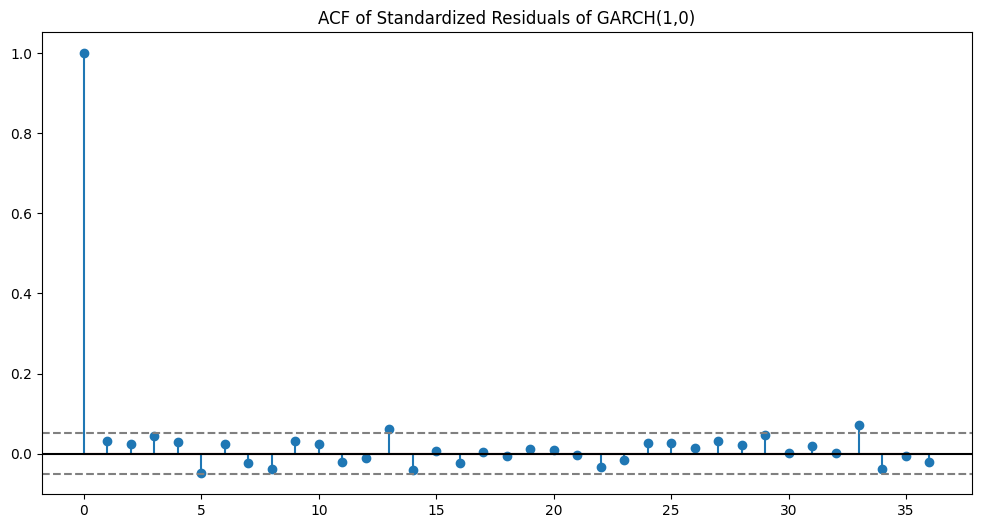

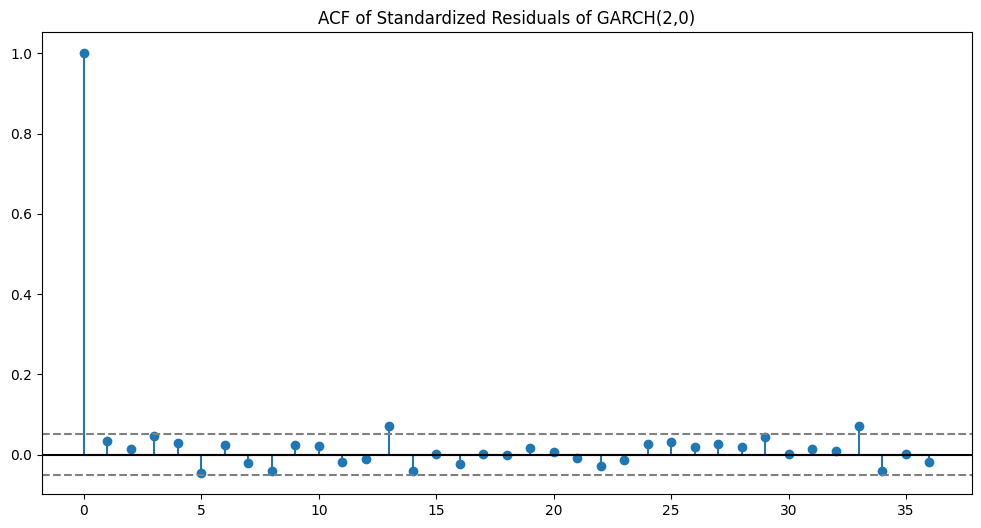

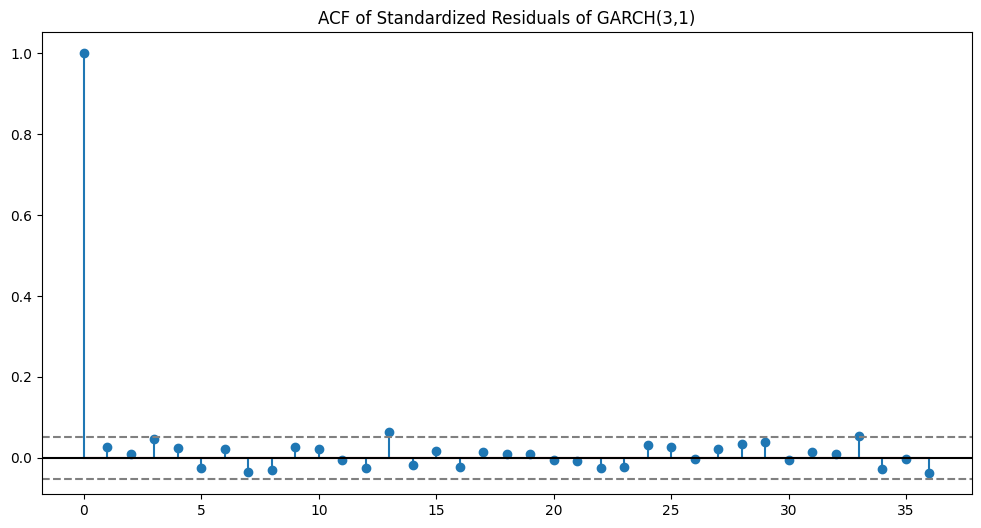

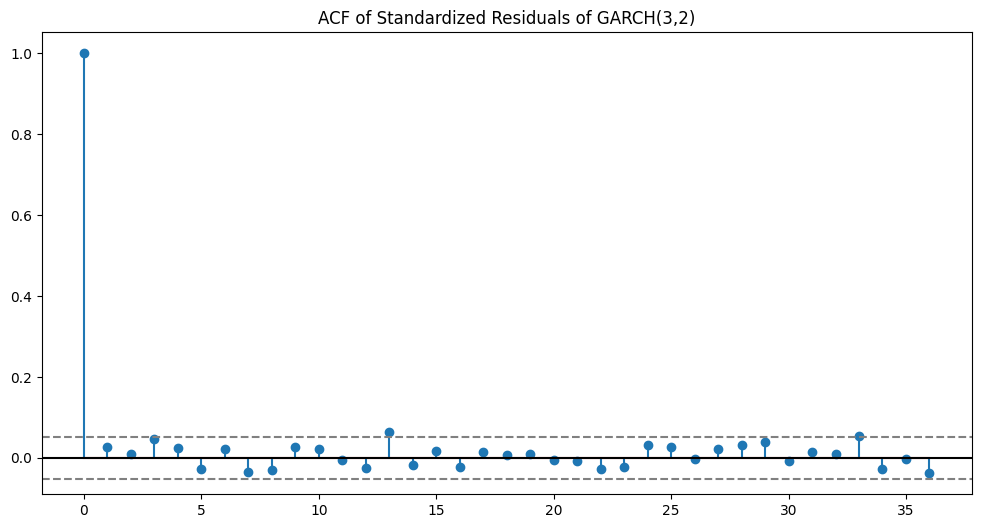

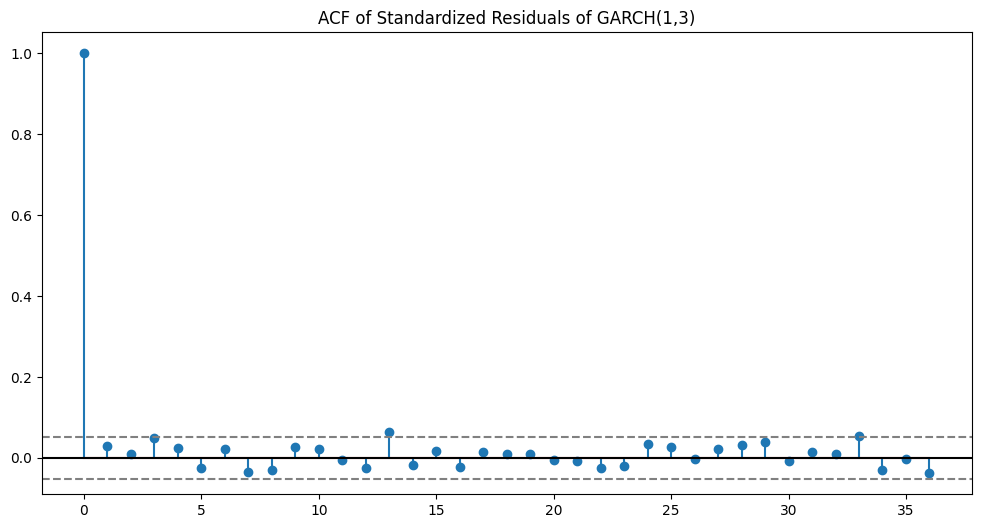

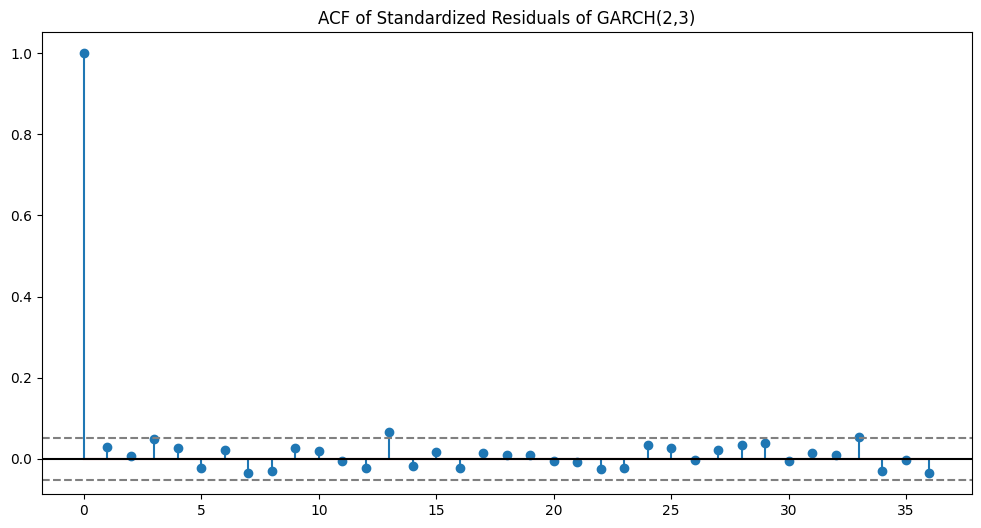

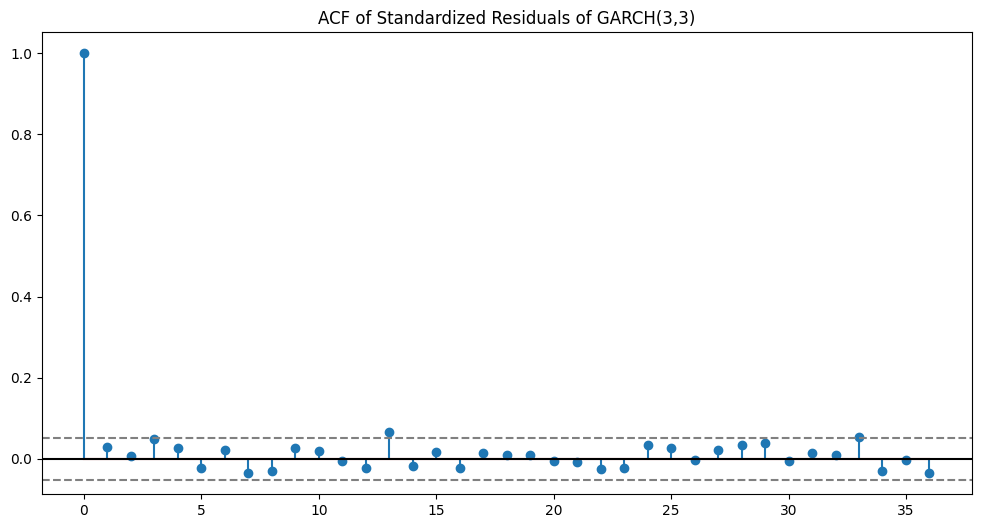

In [645]:
for name, model in models.items():
    acf(model.std_resid, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf(model.std_resid, nlags=36))), acf(model.std_resid, nlags=36))
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(model.std_resid)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(model.std_resid)), linestyle='--', color='gray')
    plt.title(f'ACF of Standardized Residuals of {name}')
    plt.show()

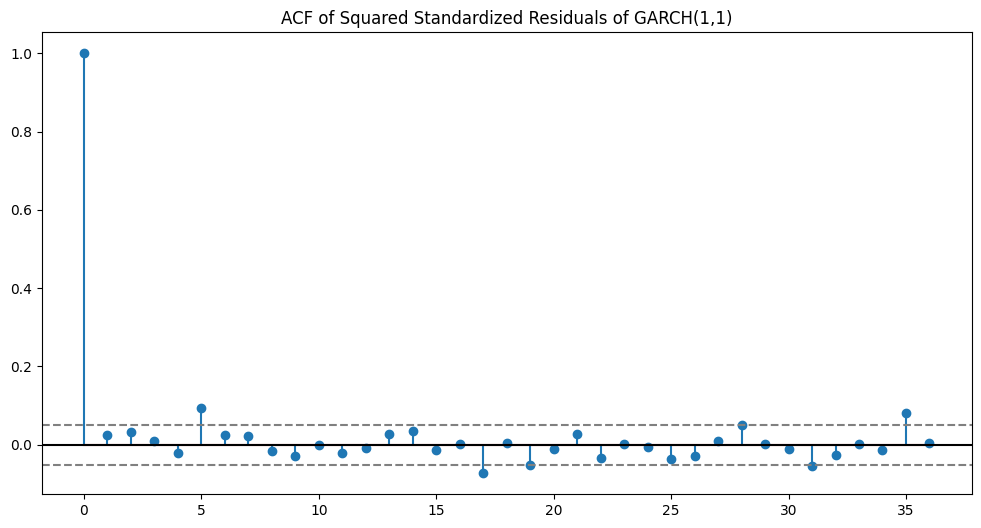

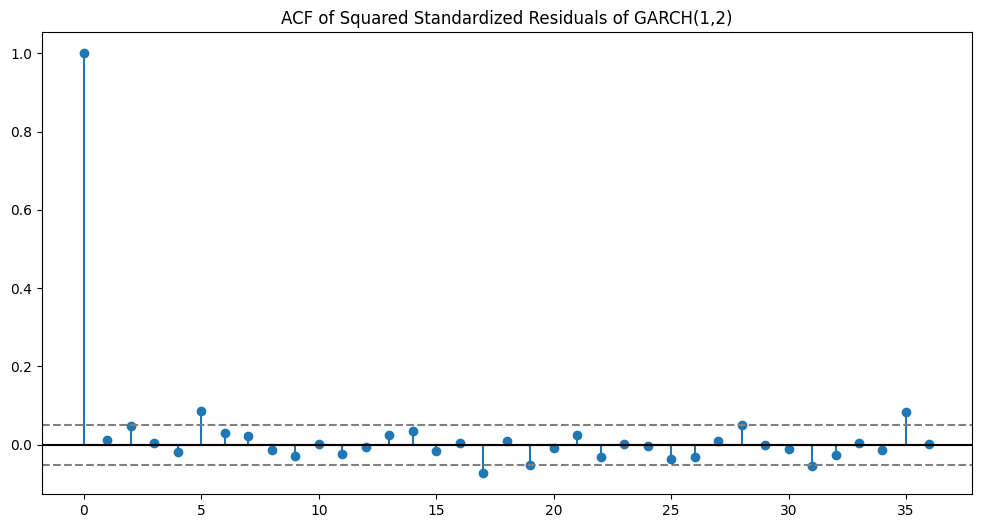

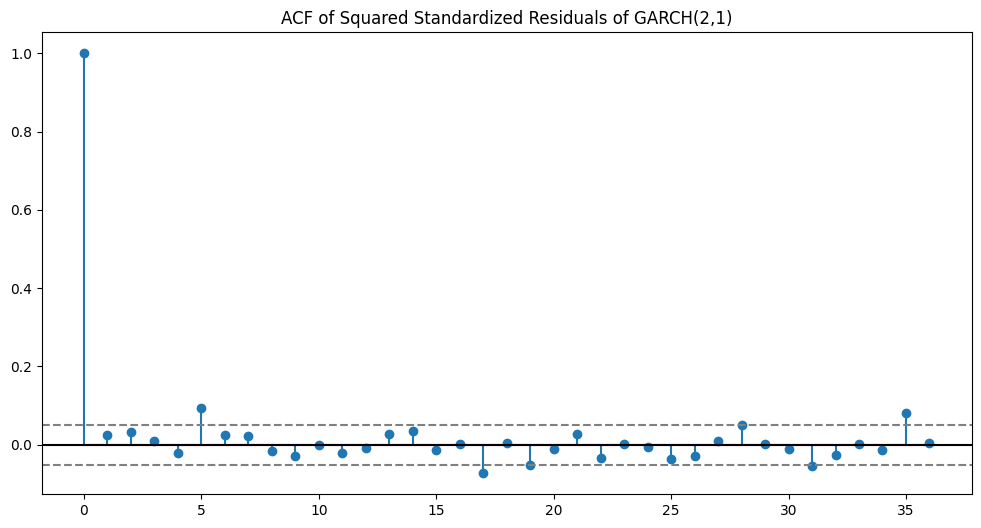

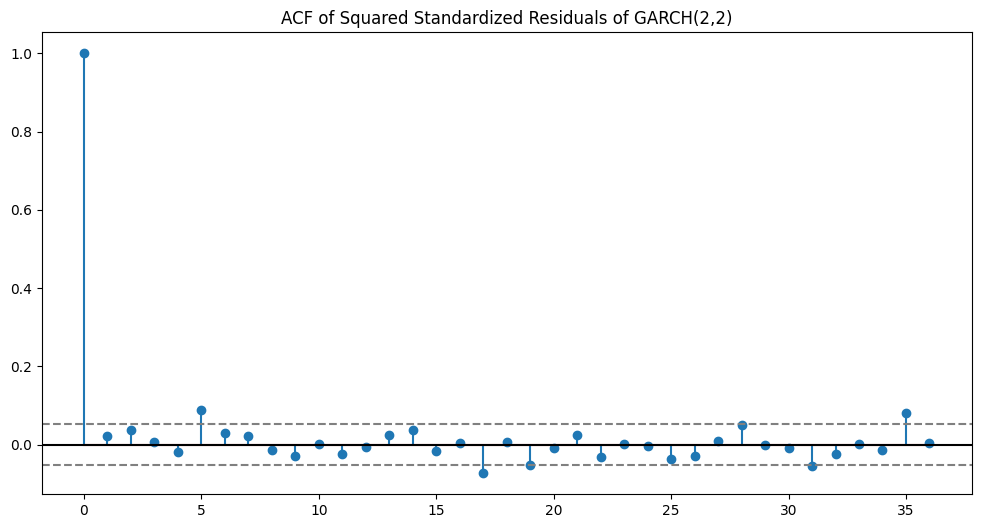

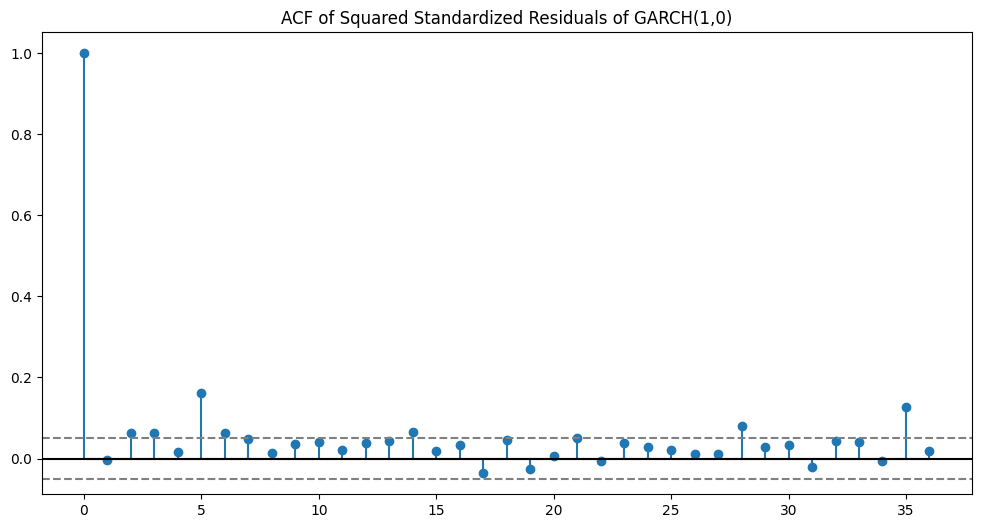

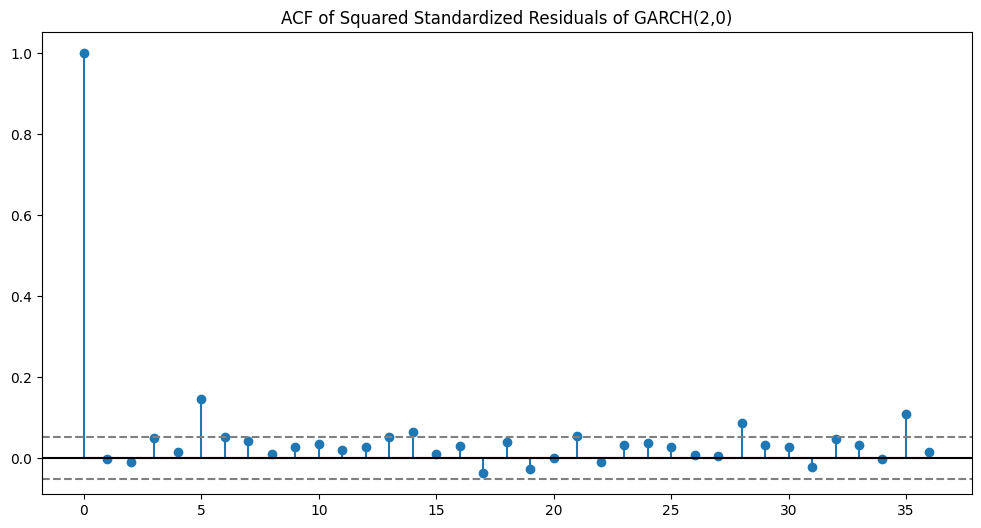

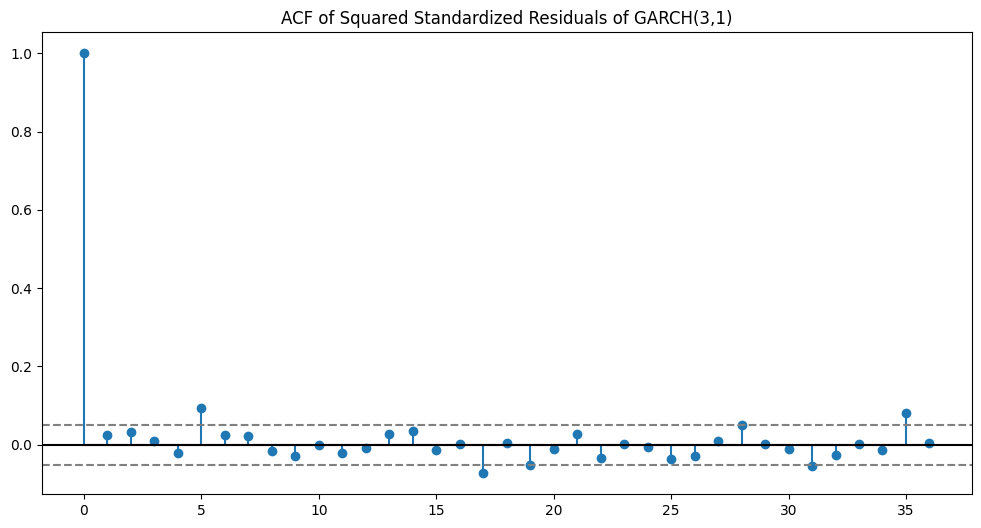

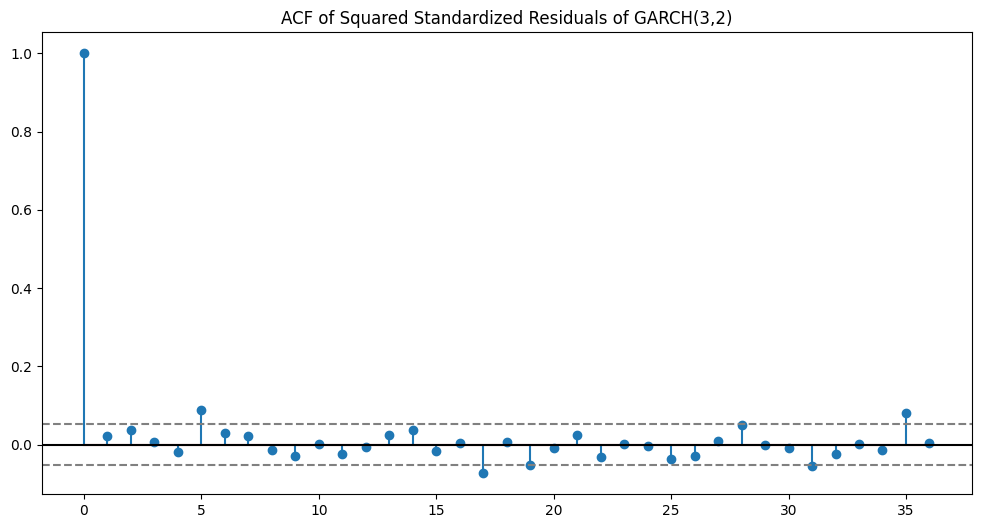

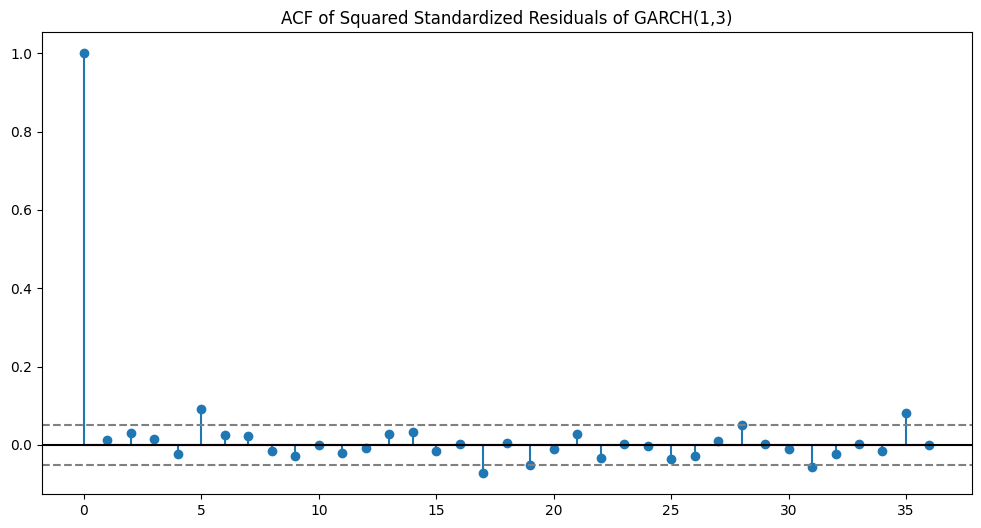

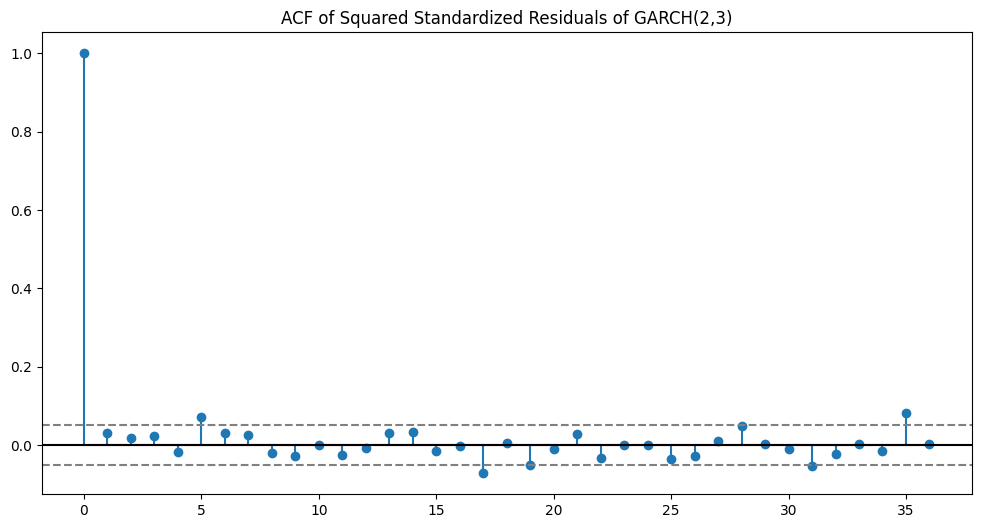

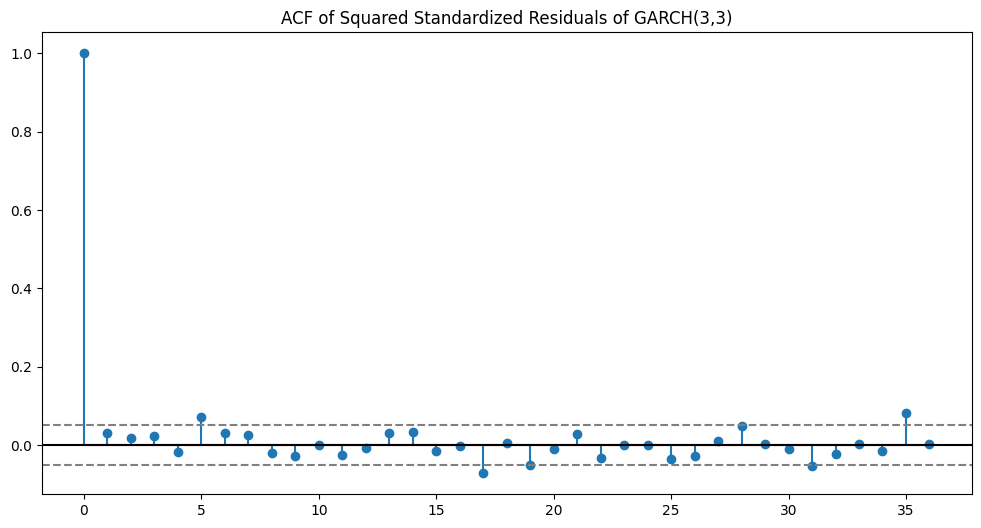

In [646]:
for name, model in models.items():
    acf(model.std_resid**2, nlags=36)
    plt.figure(figsize=(12, 6))
    plt.stem(range(len(acf(model.std_resid**2, nlags=36))), acf(model.std_resid**2, nlags=36))
    plt.axhline(y=0, linestyle='-', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(model.std_resid**2)), linestyle='--', color='gray')
    plt.axhline(y=1.96/np.sqrt(len(model.std_resid**2)), linestyle='--', color='gray')
    plt.title(f'ACF of Squared Standardized Residuals of {name}')
    plt.show()


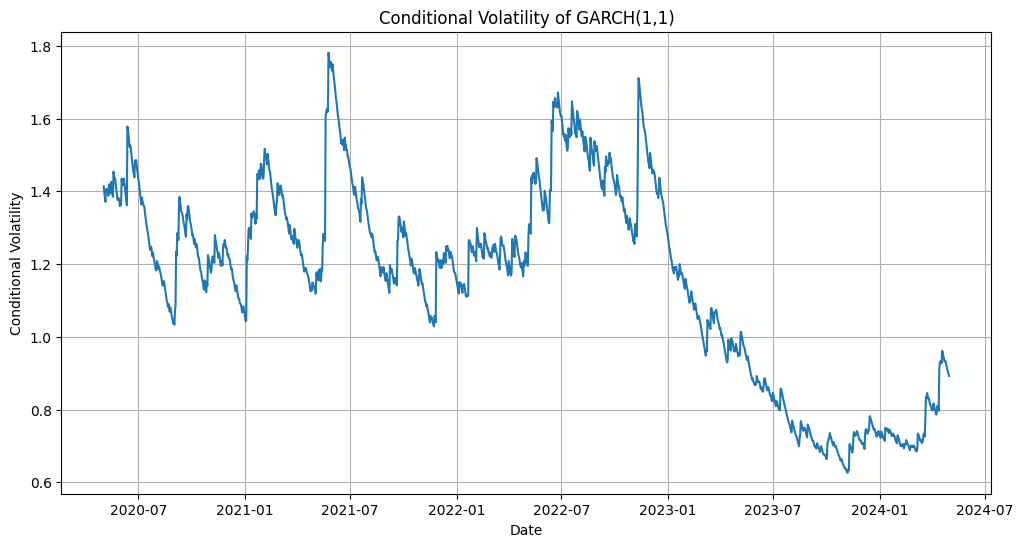

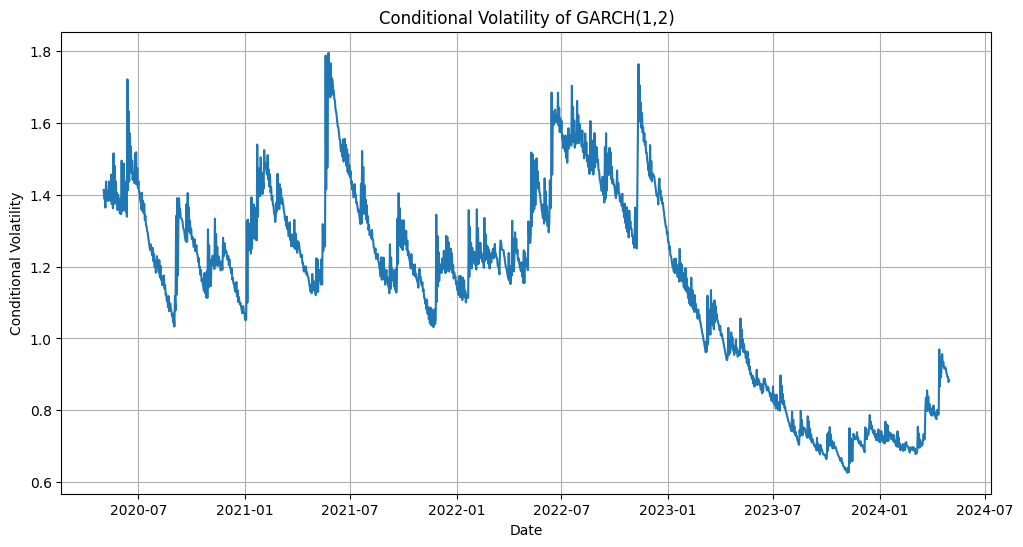

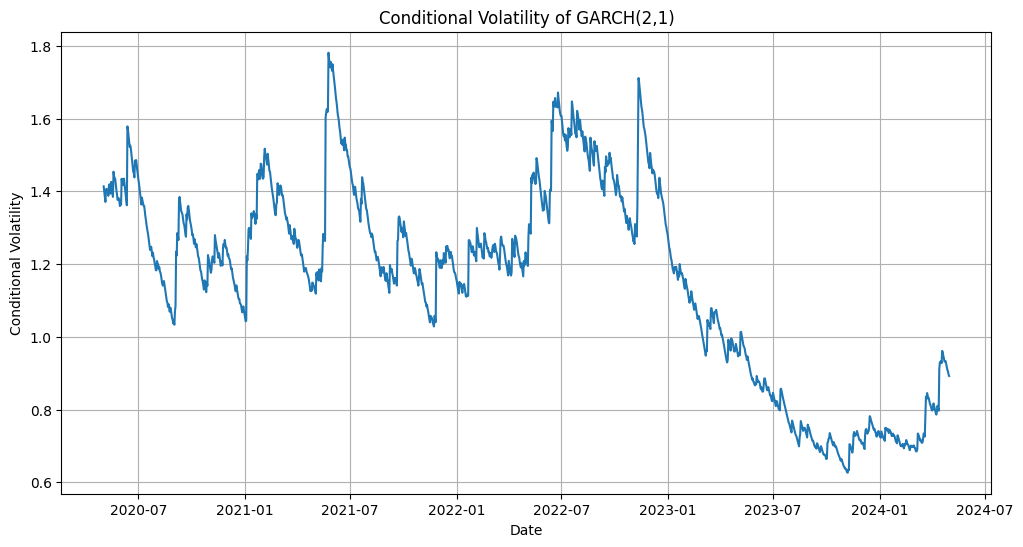

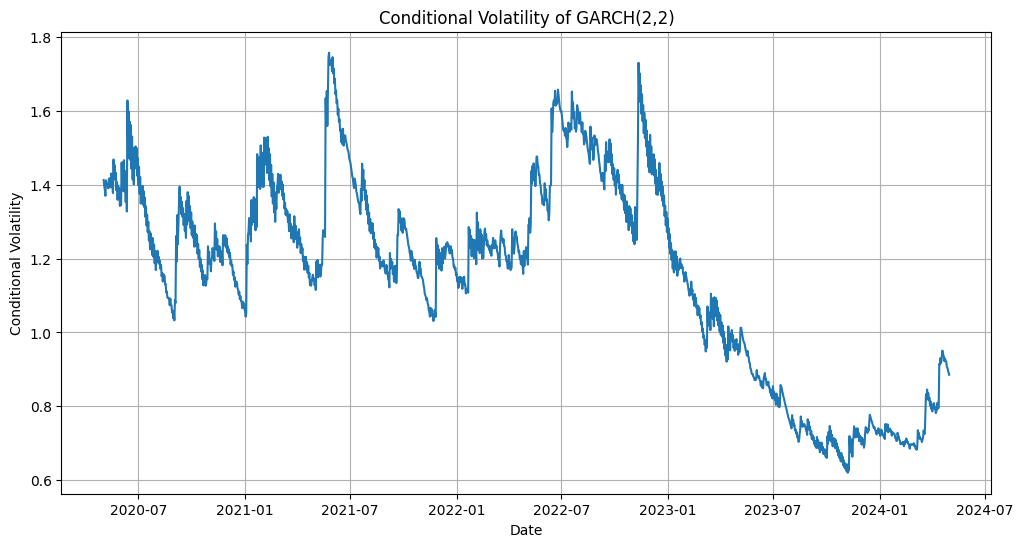

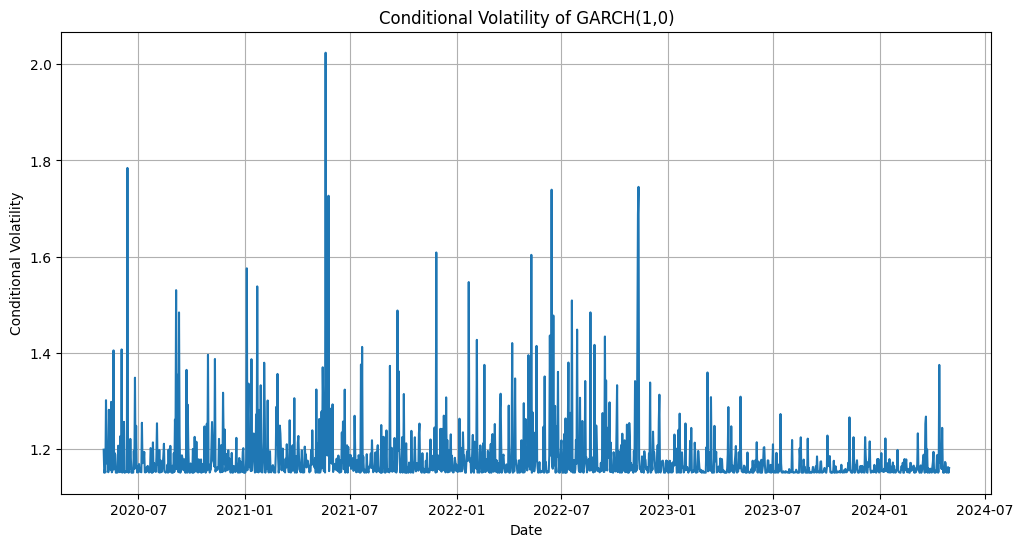

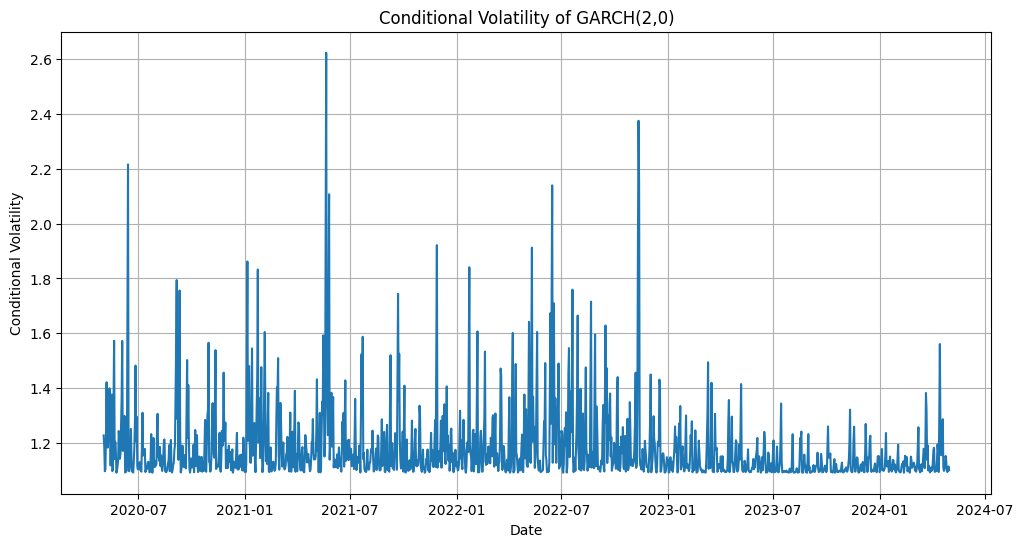

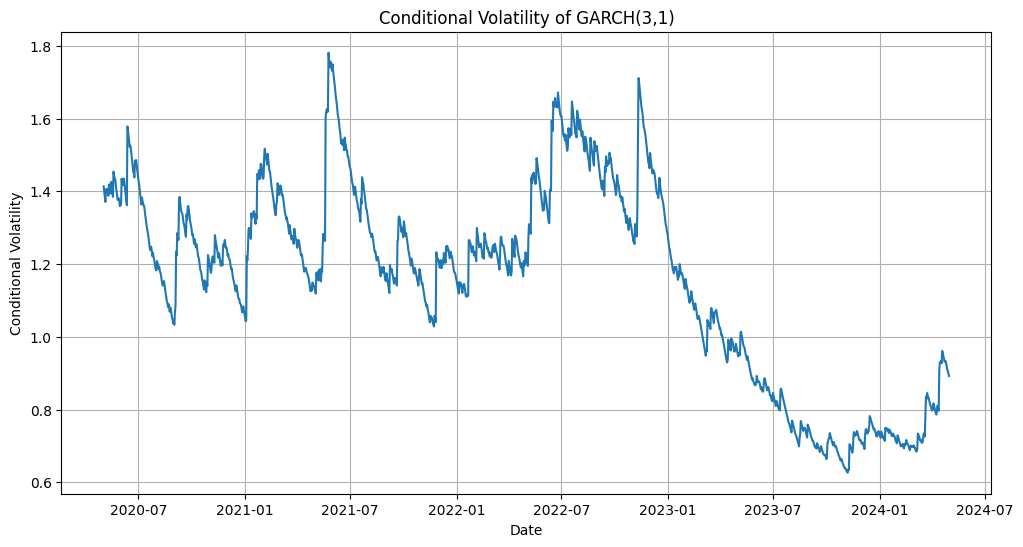

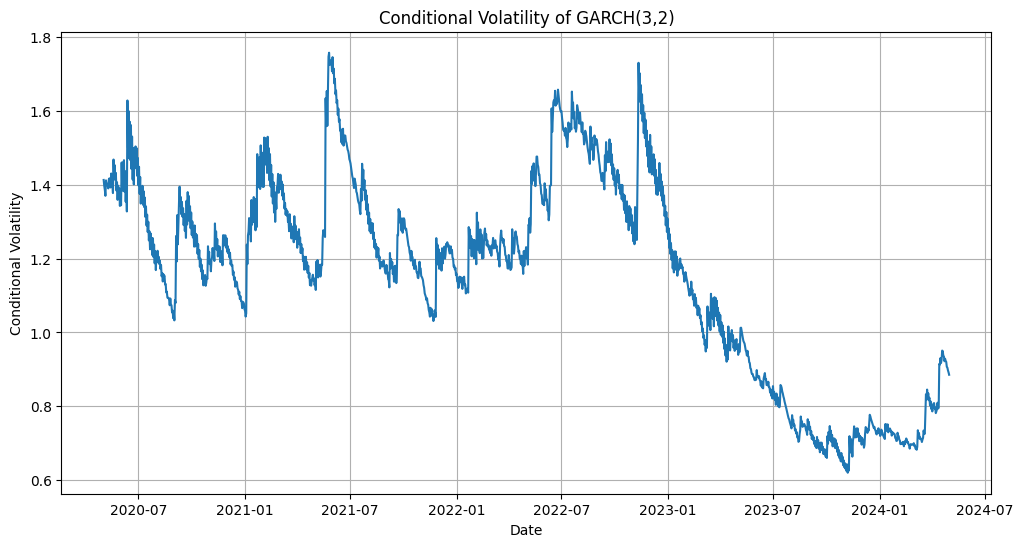

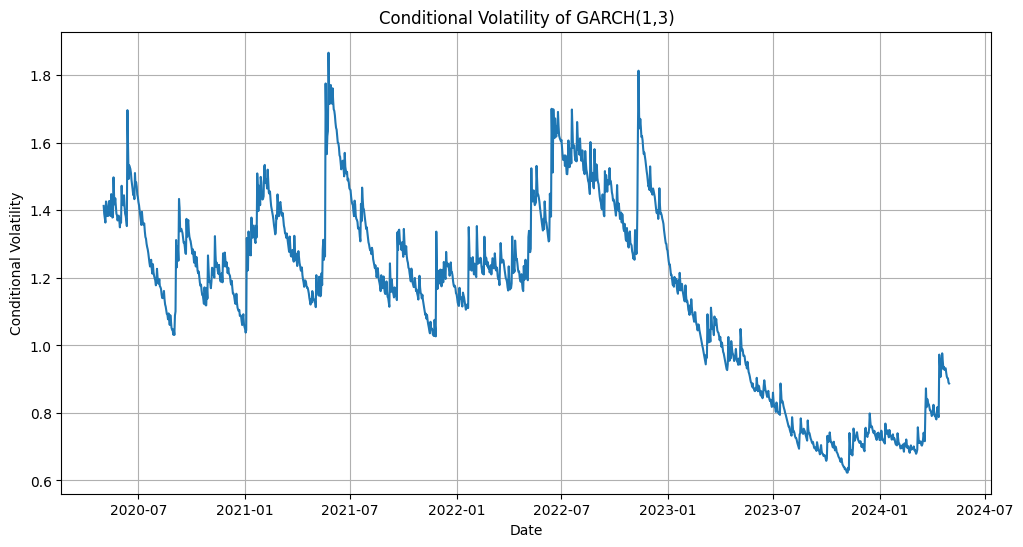

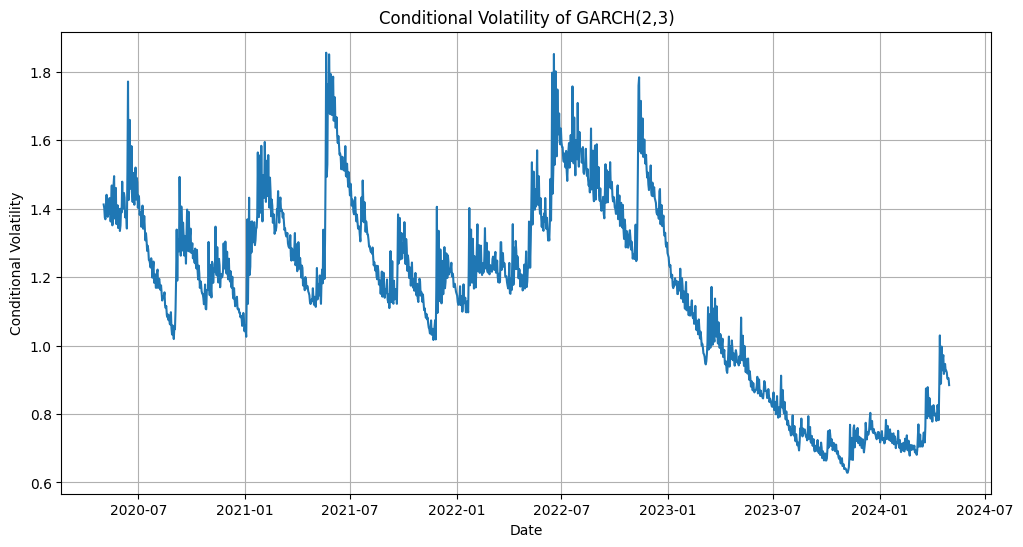

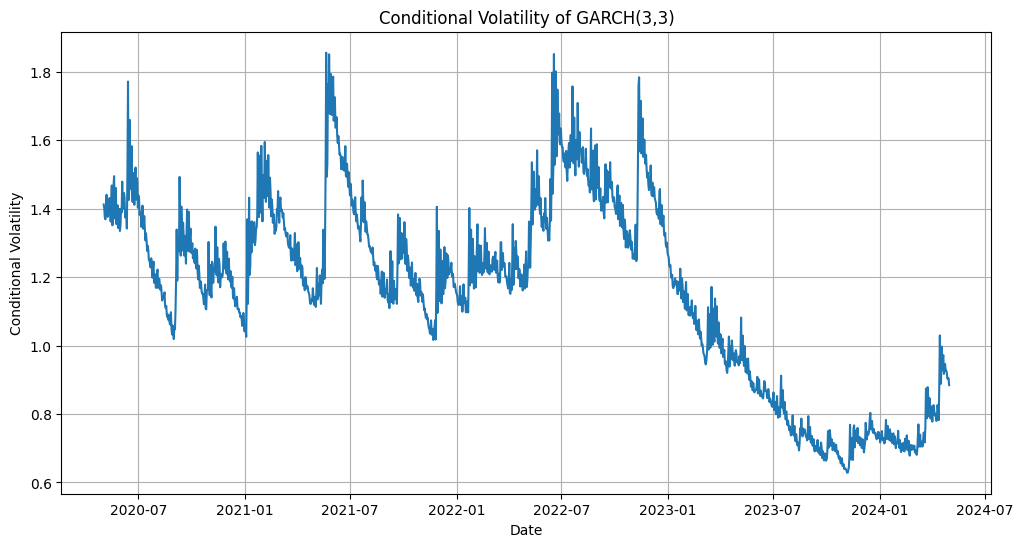

In [647]:
for name, model in models.items():
    plt.figure(figsize=(12, 6))
    plt.plot(model.conditional_volatility)
    plt.title(f'Conditional Volatility of {name}')
    plt.xlabel('Date')
    plt.ylabel('Conditional Volatility')
    plt.grid()
    plt.show()

In [648]:
# full model p=2,q=3
full = arch_model(data_train['portfolio'] * 100, p=2, q=3).fit(disp='off')
# reduced model p=1,q=1
red  = arch_model(data_train['portfolio'] * 100, p=1, q=1).fit(disp='off')

lr_stat  = 2*(full.loglikelihood - red.loglikelihood)
df       = full.num_params - red.num_params
p_value  = 1 - stats.chi2.cdf(lr_stat, df)
print(f"LR stat={lr_stat:.2f}, df={df}, p‐value={p_value:.3f}")


LR stat=3.43, df=3, p‐value=0.330


In [649]:
model_egarch111 = arch_model(data_train['portfolio'] * 100, vol='EGARCH', p=1, o=1, q=1)
results_egarch111 = model_egarch111.fit(disp='off')
print(results_egarch111.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2242.47
Distribution:                  Normal   AIC:                           4494.94
Method:            Maximum Likelihood   BIC:                           4521.37
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0641  2.713e-02      2.363  1.813e-02 [1.093e-0

In [650]:
model_egarch121 = arch_model(data_train['portfolio'] * 100, vol='EGARCH', p=1, o=2, q=1)
results_egarch121 = model_egarch121.fit(disp='off')
print(results_egarch121.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -2235.86
Distribution:                  Normal   AIC:                           4483.71
Method:            Maximum Likelihood   BIC:                           4515.43
                                        No. Observations:                 1460
Date:                Fri, May 30 2025   Df Residuals:                     1459
Time:                        03:13:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0667  2.677e-02      2.492  1.269e-02 [1.425e-0

In [651]:
lr_stat  = 2*(results_egarch121.loglikelihood - results_egarch111.loglikelihood)
df       = results_egarch121.num_params - results_egarch111.num_params
p_value  = 1 - stats.chi2.cdf(lr_stat, df)
print(f"LR stat={lr_stat:.2f}, df={df}, p‐value={p_value:.3f}")

LR stat=13.23, df=1, p‐value=0.000


In [652]:
good_models = {
    'GARCH(1,1)': results_garch11,
    'EGARCH(1,2,1)': results_egarch121
}

In [653]:
from statsmodels.stats.diagnostic import breaks_cusumolsresid, breaks_hansen
def garch_model_diagnostics(models, gof_bins=20):
    """
    Run CUSUM & Hansen stability tests, Engle–Ng sign/size‐bias tests,
    and an Adjusted‐Pearson GOF on a dict of fitted ARCH/GARCH results.

    Parameters
    ----------
    models : dict
        { model_name : fitted_arch_results_object, … }
    gof_bins : int
        # of bins for the GOF χ² test.

    Returns
    -------
    pd.DataFrame
        Index = model names; columns are test stats and p-values.
    """
    rows = []
    for name, res in models.items():
        # 1) Standardized residuals
        std = res.std_resid.dropna()
        n   = len(std)

        # 2) CUSUM & Hansen (parameter‐stability)
        sup_b, p_cusum, crit_cusum = breaks_cusumolsresid(std, ddof=res.params.shape[0])
        # Hansen’s test needs an OLSResults on a constant
        ols_res = sm.OLS(std, np.ones((n, 1))).fit()
        stat_hansen, crit_hansen = breaks_hansen(ols_res)

        # 3) Engle–Ng sign and size bias
        y   = std**2
        d   = (std.shift(1) < 0).astype(int).fillna(0)
        neg = d * std.shift(1)
        pos = (1 - d) * std.shift(1)
        X = pd.DataFrame({
            'const': 1,
            'sign_bias': d,
            'neg_size': neg,
            'pos_size': pos
        }).fillna(0)
        ng = sm.OLS(y, X).fit()
        f_stat = ng.fvalue
        p_ng   = ng.f_pvalue

        # 4) Adjusted‐Pearson GOF on the PIT of std_resid
        dist_name = res.model.distribution.name.lower()
        if 't' in dist_name:
            dfree = res.params.get('nu', None)
            u = stats.t.cdf(std, df=dfree) if dfree is not None else stats.t.cdf(std, *res.model.distribution.parameters)
        else:
            u = stats.norm.cdf(std)

        counts, _ = np.histogram(u, bins=gof_bins)
        expected  = np.ones_like(counts) * n / len(counts)
        chi2, p_gof = stats.chisquare(counts, f_exp=expected)

        rows.append({
            'Model'         : name,
            'CUSUM_stat'    : sup_b,
            'CUSUM_p'       : p_cusum,
            'Hansen_stat'   : stat_hansen,
            'Hansen_crit'   : crit_hansen,
            # no p-value from Hansen; compare stat→crit if desired
            'EngleNg_F'     : f_stat,
            'EngleNg_p'     : p_ng,
            'GOF_chi2'      : chi2,
            'GOF_p'         : p_gof
        })

    df = pd.DataFrame(rows).set_index('Model')
    return df

garch_model_diagnostics(good_models)

,CUSUM_stat,CUSUM_p,Hansen_stat,Hansen_crit,EngleNg_F,EngleNg_p,GOF_chi2,GOF_p
Model,,,,,,,,
"GARCH(1,1)",1.541592,0.017251,0.774480,"[[2, 1.01], [6, 1.9], [15, 3.75], [19, 4.52]]",1.980724,0.114960,113.726027,1.632901e-15
"EGARCH(1,2,1)",1.562622,0.015140,0.707598,"[[2, 1.01], [6, 1.9], [15, 3.75], [19, 4.52]]",0.104317,0.957561,103.808219,1.088298e-13


In [654]:
def news_impact_curve(shocks, omega, alpha, beta, gamma=0): 
    variances = omega + alpha * shocks**2 + beta * (omega / (1 - alpha - beta)) + gamma * shocks  # Steady-state variance 
    return variances 

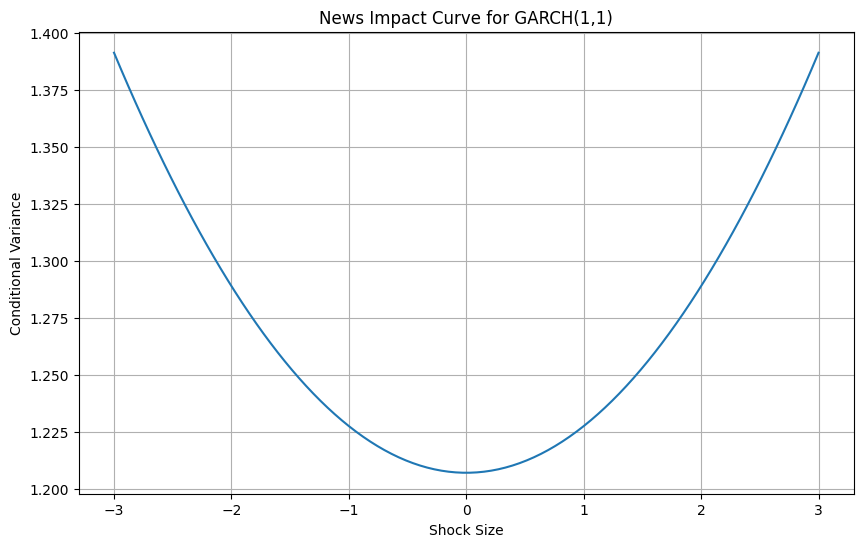

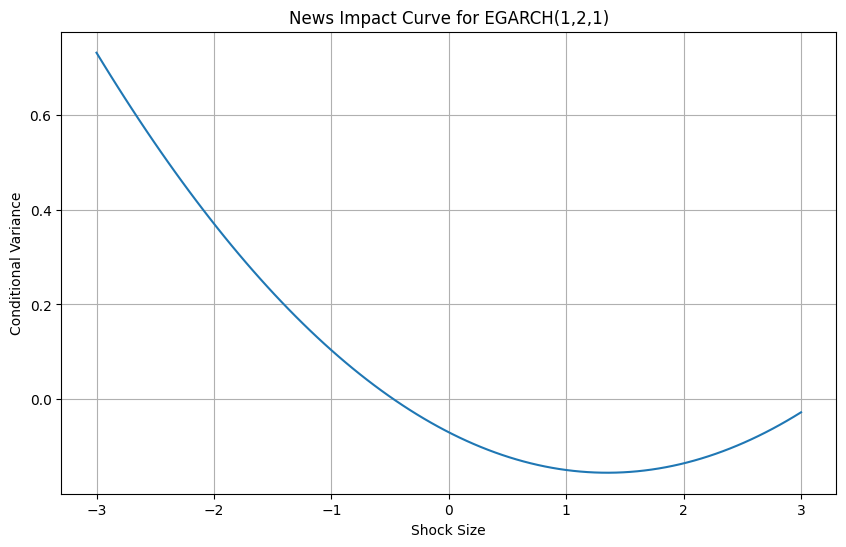

In [655]:
for name, model in good_models.items():
    variances = news_impact_curve(np.linspace(-3, 3, 100),
                                        model.params['omega'],
                                        model.params['alpha[1]'],
                                        model.params['beta[1]'],
                                        model.params.get('gamma[1]', 0))  # gamma is optional, default to 0 if not present
    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(-3, 3, 100), variances)
    plt.title(f'News Impact Curve for {name}')
    plt.xlabel('Shock Size')
    plt.ylabel('Conditional Variance')
    plt.grid()
    plt.show()  

In [656]:
data_train_portfolio = data_train['portfolio'].copy()
data_train_portfolio_mean = data_train_portfolio.mean()
data_train_portfolio_std = data_train_portfolio.std()
data_train['portfolio_std'] = (data_train_portfolio - data_train_portfolio_mean) / data_train_portfolio_std

In [657]:
q01_empirical_portfolio = data_train['portfolio_std'].quantile(0.01)
conditional_volatility_garch11 = results_garch11.conditional_volatility
conditional_volatility_egarch121 = results_egarch121.conditional_volatility

data_train.loc[conditional_volatility_garch11.index, 'VaR_GARCH(1,1)'] = q01_empirical_portfolio * conditional_volatility_garch11
data_train.loc[conditional_volatility_egarch121.index, 'VaR_EGARCH(1,2,1)'] = q01_empirical_portfolio * conditional_volatility_egarch121

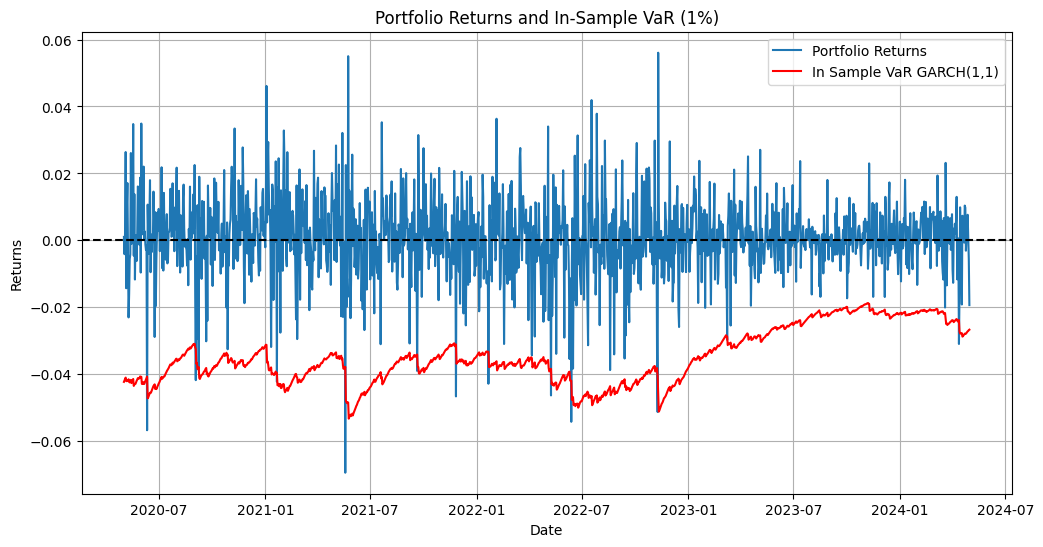

In [658]:
# Plot returns and VaR for GARCH(1,1)
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['portfolio'], label='Portfolio Returns')
plt.plot(data_train.index, data_train['VaR_GARCH(1,1)'] / 100, label='In Sample VaR GARCH(1,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and In-Sample VaR (1%)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

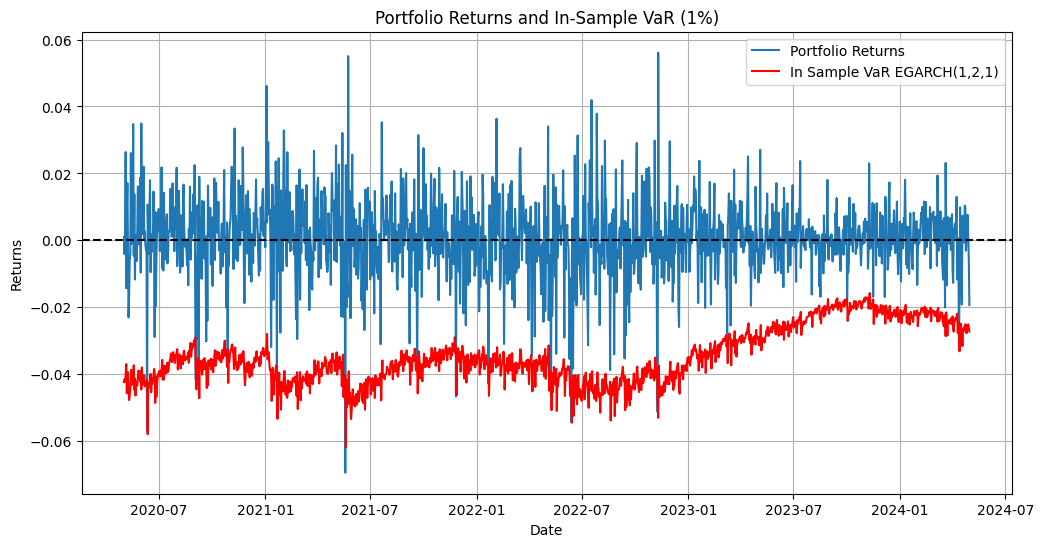

In [659]:
# Plot returns and VaR for EGARCH(1,2,1)
plt.figure(figsize=(12, 6))
plt.plot(data_train.index, data_train['portfolio'], label='Portfolio Returns')
plt.plot(data_train.index, data_train['VaR_EGARCH(1,2,1)'] / 100, label='In Sample VaR EGARCH(1,2,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and In-Sample VaR (1%)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

In [660]:
# Number and share of observations below VaR
def calculate_var_metrics(dataframe, var_column):
    below_var = dataframe[dataframe['portfolio'] < (dataframe[var_column] / 100)]
    num_below_var = len(below_var)
    share_below_var = num_below_var / len(dataframe) * 100
    return num_below_var, share_below_var

In [661]:
below_var_garch = calculate_var_metrics(data_train, 'VaR_GARCH(1,1)')
below_var_egarch = calculate_var_metrics(data_train, 'VaR_EGARCH(1,2,1)')

print(f"GARCH(1,1) - Number of observations below VaR: {below_var_garch[0]}, Share: {below_var_garch[1]:.2f}%")
print(f"EGARCH(1,2,1) - Number of observations below VaR: {below_var_egarch[0]}, Share: {below_var_egarch[1]:.2f}%")

GARCH(1,1) - Number of observations below VaR: 13, Share: 0.89%
EGARCH(1,2,1) - Number of observations below VaR: 13, Share: 0.89%


In [662]:
data_test_portfolio = data_test['portfolio'].copy()
data_test_portfolio_mean = data_test_portfolio.mean()
data_test_portfolio_std = data_test_portfolio.std()
data_test['portfolio_std'] = (data_test_portfolio - data_test_portfolio_mean) / data_test_portfolio_std

In [663]:
VaR_garch11 = np.zeros(len(data_test))
VaR_egarch121 = np.zeros(len(data_test))

for i in range(len(data_test)):
    current_forecast_target_date = data_test.index[i]
    tmp_estimation_data = data[data.index < current_forecast_target_date].copy()
    tmp_estimation_data['portfolio_std'] = (tmp_estimation_data['portfolio'] - tmp_estimation_data['portfolio'].mean()) / tmp_estimation_data['portfolio'].std()
    qo1_rolling_empirical_portfolio = tmp_estimation_data['portfolio_std'].quantile(0.01)

    model_rolling_garch11 = arch_model(tmp_estimation_data['portfolio'] * 100, vol='Garch', p=1, q=1)
    results_rolling_garch11 = model_rolling_garch11.fit(disp='off')
    model_rolling_egarch121 = arch_model(tmp_estimation_data['portfolio'] * 100, vol='EGARCH', p=1, o=2, q=1)
    results_rolling_egarch121 = model_rolling_egarch121.fit(disp='off')

    forecast_rolling_garch11 = results_rolling_garch11.forecast(horizon=1, reindex=False)
    forecast_rolling_egarch121 = results_rolling_egarch121.forecast(horizon=1, reindex=False)

    sigma_forecast_rolling_garch11 = forecast_rolling_garch11.variance.iloc[-1, 0] ** 0.5
    sigma_forecast_rolling_egarch121 = forecast_rolling_egarch121.variance.iloc[-1, 0] ** 0.5

    VaR_garch11[i] = qo1_rolling_empirical_portfolio * sigma_forecast_rolling_garch11
    VaR_egarch121[i] = qo1_rolling_empirical_portfolio * sigma_forecast_rolling_egarch121



In [664]:
data_test['VaR_GARCH(1,1)'] = VaR_garch11
data_test['VaR_EGARCH(1,2,1)'] = VaR_egarch121

In [665]:
data_test

,JPMorgan,BrentOil,Ethereum,NASDAQ,PLNUSD,portfolio,portfolio_std,"VaR_GARCH(1,1)","VaR_EGARCH(1,2,1)"
Date,,,,,,,,,
2024-05-01,0.000626,-0.051617,-0.014210,-0.007028,-0.008510,-0.016148,-1.405310,-2.777660,-3.091568
2024-05-02,-0.001043,0.002753,0.006171,0.012794,0.006472,0.005429,0.498039,-2.851432,-3.046247
2024-05-03,-0.006018,-0.008522,0.037883,0.019715,-0.000014,0.008609,0.778499,-2.826687,-2.638935
2024-05-04,0.000000,0.000000,0.004512,0.000000,0.000000,0.000902,0.098712,-2.817968,-2.578273
2024-05-05,0.000000,0.000000,0.006290,0.000000,0.000000,0.001258,0.130089,-2.785626,-2.679992
...,...,...,...,...,...,...,...,...,...
2025-04-26,0.000000,0.000000,0.019536,0.000000,0.000000,0.003907,0.363768,-5.419659,-4.783099
2025-04-27,0.000000,0.000000,-0.016055,0.000000,0.000000,-0.003211,-0.264128,-5.332893,-4.711674
2025-04-28,-0.001356,-0.015219,0.003334,-0.000271,-0.002023,-0.003107,-0.254981,-5.250016,-4.744719


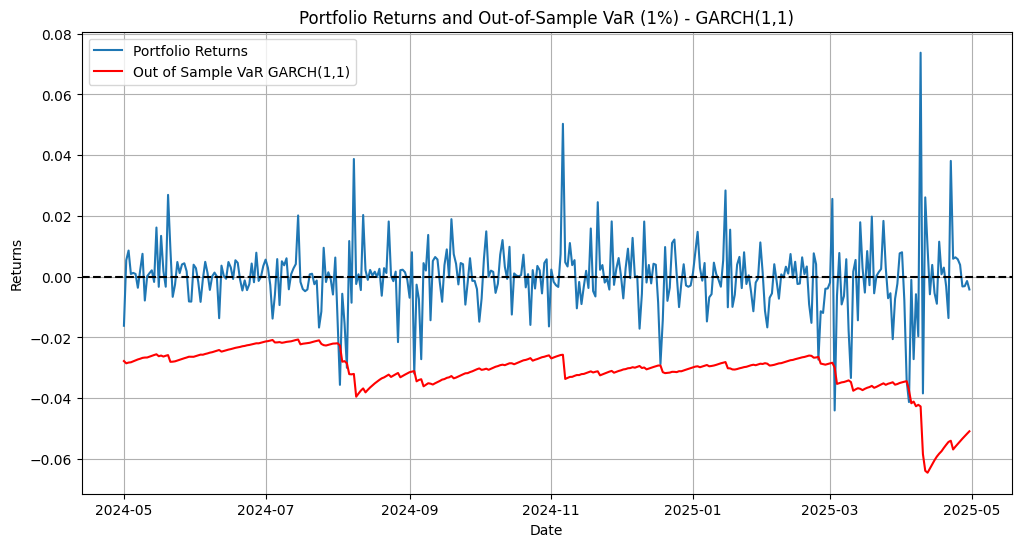

In [666]:
# Plot returns and VaR for GARCH(1,1) in test set
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['portfolio'], label='Portfolio Returns')
plt.plot(data_test.index, data_test['VaR_GARCH(1,1)'] / 100, label='Out of Sample VaR GARCH(1,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and Out-of-Sample VaR (1%) - GARCH(1,1)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

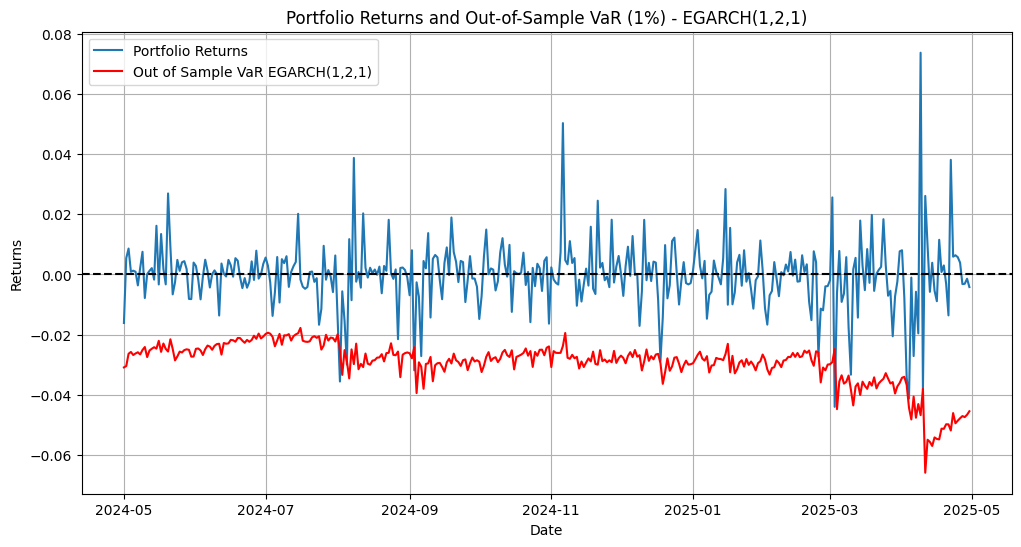

In [667]:
# Plot returns and VaR for EGARCH(1,2,1) in test set
plt.figure(figsize=(12, 6))
plt.plot(data_test.index, data_test['portfolio'], label='Portfolio Returns')
plt.plot(data_test.index, data_test['VaR_EGARCH(1,2,1)'] / 100, label='Out of Sample VaR EGARCH(1,2,1)', color='red')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Portfolio Returns and Out-of-Sample VaR (1%) - EGARCH(1,2,1)')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid()
plt.show()

In [668]:
# Number and share of observations below VaR in test set
below_var_test_garch = calculate_var_metrics(data_test, 'VaR_GARCH(1,1)')
below_var_test_egarch = calculate_var_metrics(data_test, 'VaR_EGARCH(1,2,1)')
print(f"GARCH(1,1) - Number of observations below VaR in test set: {below_var_test_garch[0]} out of {len(data_test)}, Share: {below_var_test_garch[1]:.2f}%")
print(f"EGARCH(1,2,1) - Number of observations below VaR in test set: {below_var_test_egarch[0]} out of {len(data_test)}, Share: {below_var_test_egarch[1]:.2f}%")

GARCH(1,1) - Number of observations below VaR in test set: 6 out of 365, Share: 1.64%
EGARCH(1,2,1) - Number of observations below VaR in test set: 6 out of 365, Share: 1.64%
